In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import missingno as msno
import os

%matplotlib inline

In [3]:
plt.rcParams['font.family'] = "NanumGothic"

In [4]:
data_path = '../data/train'
train_df = pd.read_csv(os.path.join(data_path, 'train_ratings.csv')) # 전체 학습 데이터

num_train_users = train_df['user'].nunique()
num_train_items = train_df['item'].nunique()

print ("Number of unique train users: ", num_train_users)
print ("Number of unique train items: ", num_train_items)

print("Data sparsity ratio: ", 1 - len(train_df) / (num_train_users * num_train_items))

Number of unique train users:  31360
Number of unique train items:  6807
Data sparsity ratio:  0.9758536052697853


In [5]:
year_data = pd.read_csv(os.path.join(data_path, 'years.tsv'), sep='\t')
writer_data = pd.read_csv(os.path.join(data_path, 'writers.tsv'), sep='\t')
title_data = pd.read_csv(os.path.join(data_path, 'titles.tsv'), sep='\t')
genre_data = pd.read_csv(os.path.join(data_path, 'genres.tsv'), sep='\t')
director_data = pd.read_csv(os.path.join(data_path, 'directors.tsv'), sep='\t')

# train_rating.csv

In [6]:
print(train_df['user'].value_counts())
print()
print("총 user 수 : ", train_df['user'].count())
print("nunique user 수 : ", train_df['user'].nunique())

8405      2912
54465     1980
24219     1842
32514     1830
91349     1795
          ... 
11211       32
128756      28
105578      22
68606       19
53188       16
Name: user, Length: 31360, dtype: int64

총 user 수 :  5154471
nunique user 수 :  31360


In [7]:
print(train_df['item'].value_counts())
print()
print("총 item 수 : ", train_df['item'].count())
print("nunique item 수 : ", train_df['item'].nunique())

2571     19699
2959     18437
296      18202
318      18168
356      17339
         ...  
7259        38
126         36
4241        34
2555        34
51372       27
Name: item, Length: 6807, dtype: int64

총 item 수 :  5154471
nunique item 수 :  6807


## 연도 / 월 생성

In [8]:
train_df['time'] = train_df['time'].apply(lambda x : time.strftime("%Y-%m", time.localtime(x)))
train_df['time'] = pd.to_datetime(train_df['time'])
train_df['time']

0         2009-01-01
1         2009-01-01
2         2009-01-01
3         2009-01-01
4         2009-01-01
             ...    
5154466   2009-12-01
5154467   2009-12-01
5154468   2009-12-01
5154469   2009-12-01
5154470   2009-12-01
Name: time, Length: 5154471, dtype: datetime64[ns]

In [9]:
train_df['year'] = train_df['time'].dt.year
train_df['month'] = train_df['time'].dt.month
train_df

,user,item,time,year,month
0,11,4643,2009-01-01,2009,1
1,11,170,2009-01-01,2009,1
2,11,531,2009-01-01,2009,1
3,11,616,2009-01-01,2009,1
4,11,2140,2009-01-01,2009,1
...,...,...,...,...,...
5154466,138493,44022,2009-12-01,2009,12
5154467,138493,4958,2009-12-01,2009,12
5154468,138493,68319,2009-12-01,2009,12
5154469,138493,40819,2009-12-01,2009,12


2008    679269
2006    647240
2007    589945
2005    572894
2009    517366
2010    510385
2011    427103
2012    421942
2013    338109
2014    308281
2015    141937
Name: year, dtype: int64

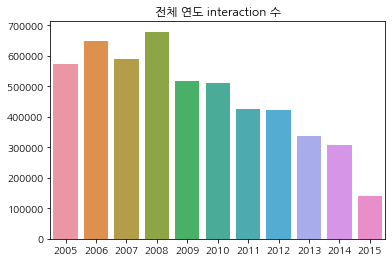

In [24]:
fig = plt.figure()
k = train_df['year'].value_counts()
display(k)
k = k.sort_index()
sns.barplot(x=k.index, y=k.values)
plt.title("전체 연도 interaction 수")
plt.show()

2015년 데이터가 interaction이 많이 부족

1     508889
11    444009
10    442310
7     440935
5     439160
3     432249
12    431259
2     417357
6     414722
4     406257
9     390955
8     386369
Name: month, dtype: int64

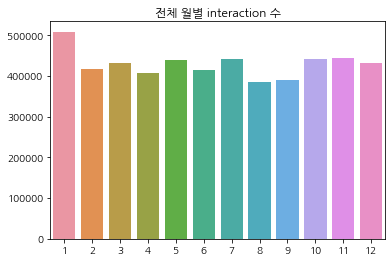

In [27]:
k = train_df['month'].value_counts()
display(k)
k = k.sort_index()
sns.barplot(x=k.index, y=k.values)
plt.title("전체 월별 interaction 수")
plt.show()

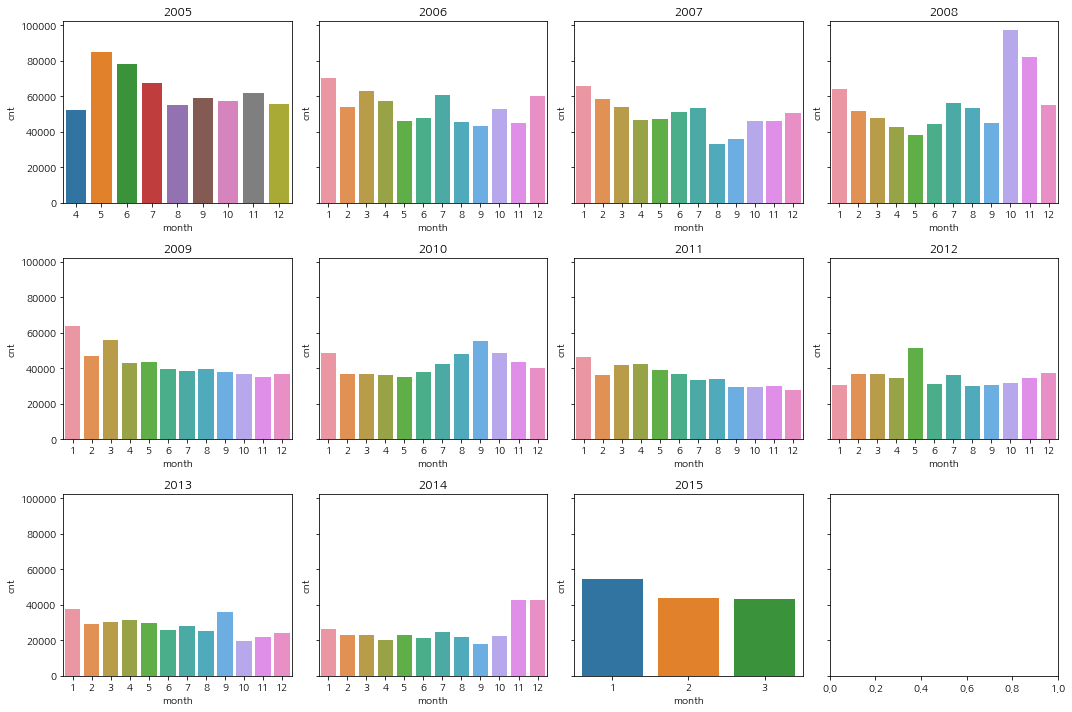

In [49]:
k = train_df.groupby(['year', 'month'])['user'].count().reset_index()
k = k.rename(columns={'user':'cnt'})
uniq_year = k['year'].unique()

fig, axes = plt.subplots(3,4,figsize=(15,10), sharey=True)
for idx, i in enumerate(uniq_year):
    t = k[k['year']==i][['month','cnt']]
    sns.barplot(x=t.month, y=t.cnt, ax=axes[idx//4][idx%4])
    axes[idx//4][idx%4].set_title(i)
    
plt.tight_layout()
plt.show()


## interaction이 많은 상위 10개 아이템 (user / item 각각)

In [43]:
uvc = train_df['user'].value_counts().values

# Q1 = np.percentile(uvc, 25)
# Q3 = np.percentile(uvc, 75)
# IQR = Q3 - Q1

# outlier_step = 1.5 * IQR

outlier_step = train_df['user'].value_counts().describe()['75%']
print("interaction이 많은 user 상위 25% : ",outlier_step)

upper_25perc = pd.DataFrame(uvc[uvc >= outlier_step], columns=['cnt'])
under_25perc = pd.DataFrame(uvc[uvc < outlier_step], columns=['cnt'])

interaction이 많은 user 상위 25% :  200.0


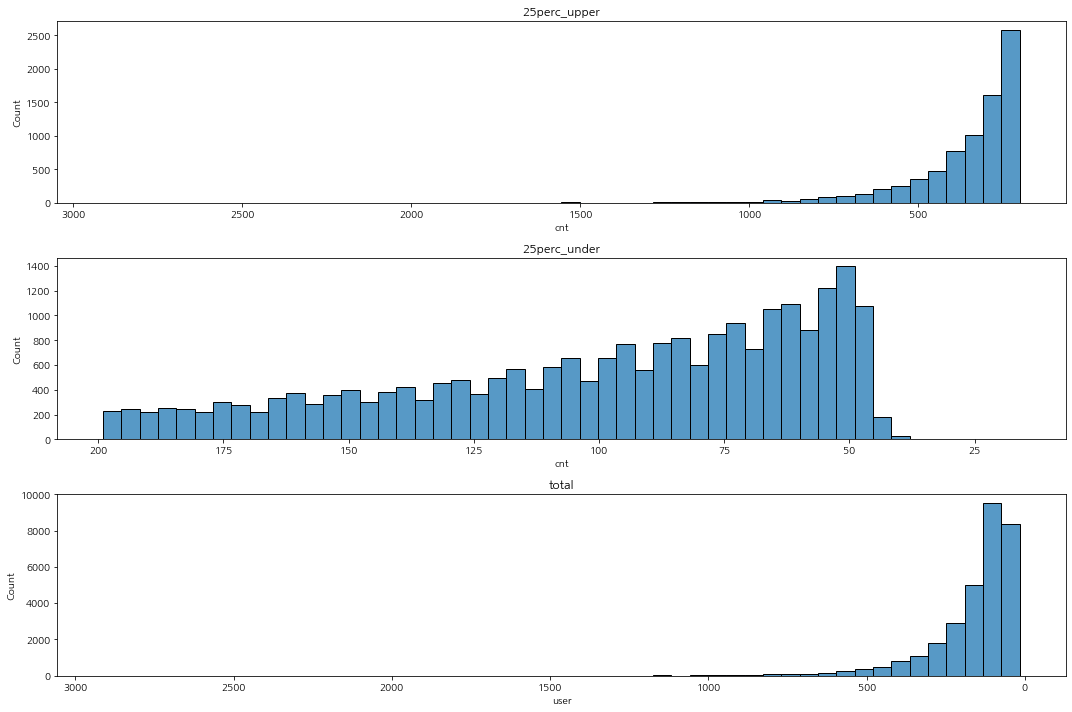

In [44]:
_, axes = plt.subplots(3,1, figsize = (15,10))

sns.histplot(upper_25perc['cnt'], bins=50, ax=axes[0])
axes[0].set_title('25perc_upper')
axes[0].invert_xaxis()

sns.histplot(under_25perc['cnt'], bins=50, ax=axes[1])
axes[1].set_title('25perc_under')
axes[1].invert_xaxis()

sns.histplot(train_df['user'].value_counts(), bins=50, ax=axes[2])
axes[2].set_title('total')
axes[2].invert_xaxis()

plt.tight_layout()
plt.show()

<AxesSubplot: xlabel='cnt', ylabel='Count'>

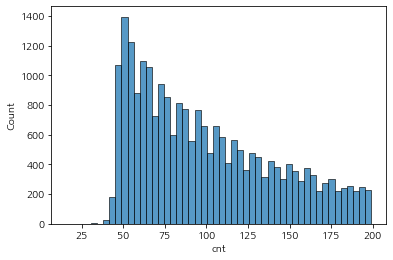

In [45]:
_ = plt.figure()
sns.histplot(under_25perc['cnt'], bins=50)

In [56]:
ivc = train_df['item'].value_counts().values

# Q1 = np.percentile(ivc, 25)
# Q3 = np.percentile(ivc, 75)
# IQR = Q3 - Q1

# outlier_step = 1.5 * IQR

outlier_step = train_df['item'].value_counts().describe()['75%']
print("interaction이 많은 item 상위 25% : ",outlier_step)

upper_25perc = pd.DataFrame(ivc[ivc >= outlier_step], columns=['cnt'])
under_25perc = pd.DataFrame(ivc[ivc < outlier_step], columns=['cnt'])

interaction이 많은 item 상위 25% :  610.5


In [61]:
upper_25perc[upper_25perc['cnt'] < 650]

,cnt
1626,649
1627,648
1628,648
1629,646
1630,645
...,...
1697,611
1698,611
1699,611
1700,611


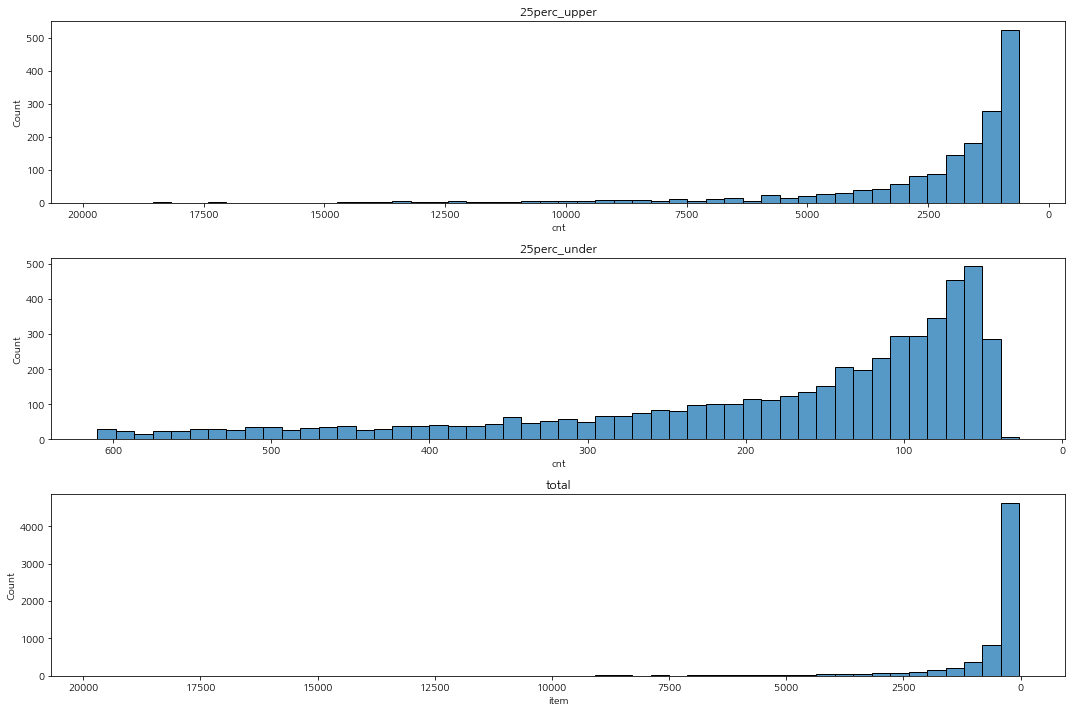

In [57]:
_, axes = plt.subplots(3,1, figsize = (15,10))

sns.histplot(upper_25perc['cnt'], bins=50, ax=axes[0])
axes[0].set_title('25perc_upper')
axes[0].invert_xaxis()

sns.histplot(under_25perc['cnt'], bins=50, ax=axes[1])
axes[1].set_title('25perc_under')
axes[1].invert_xaxis()

sns.histplot(train_df['item'].value_counts(), bins=50, ax=axes[2])
axes[2].set_title('total')
axes[2].invert_xaxis()

plt.tight_layout()
plt.show()

<AxesSubplot: xlabel='cnt', ylabel='Count'>

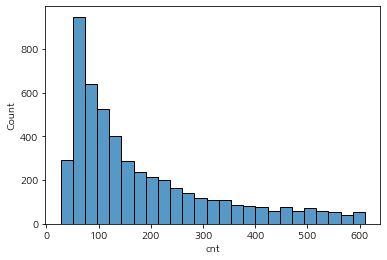

In [48]:
_ = plt.figure()
sns.histplot(under_25perc['cnt'], bins=25)

# year

In [59]:
display(year_data.info())
print()
display(year_data['year'].nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6799 entries, 0 to 6798
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   item    6799 non-null   int64
 1   year    6799 non-null   int64
dtypes: int64(2)
memory usage: 106.4 KB


None

93

In [ ]:
writer_group_df = writer_data.groupby('writer')['item'].count().reset_index()
writer_group_df = writer_group_df.rename(columns={"item":"itemCnt"})
writer_group_df['itemRatioPercent'] = writer_group_df['itemCnt']/(writer_group_df['itemCnt'].sum()) * 100
writer_group_df.sort_values('itemCnt', ascending=False)

In [67]:
print(year_data['year'].min())
print(year_data['year'].max())

1922
2014


In [69]:
year_group_df = year_data.groupby('year')['item'].count().reset_index()
year_group_df = year_gropu_df.rename(columns={"item" : "itemCnt"})
year_group_df['itemRatioPercent'] = year_group_df['itemCnt']/(year_group_df['itemCnt'].sum()) * 100
year_group_df = year_group_df.sort_values('itemCnt', ascending=False)
year_group_df

,year,itemCnt,itemRatioPercent
84,2006,284,4.177085
85,2007,271,3.985880
82,2004,262,3.853508
83,2005,260,3.824092
86,2008,256,3.765260
...,...,...,...
2,1924,5,0.073540
8,1930,4,0.058832
0,1922,3,0.044124
1,1923,2,0.029416


In [68]:
year_group_df.describe()

,year,itemCnt,itemRatioPercent
count,93.000000,93.000000,93.000000
mean,1968.000000,73.107527,1.075269
std,26.990739,78.501656,1.154606
min,1922.000000,2.000000,0.029416
25%,1945.000000,19.000000,0.279453
50%,1968.000000,37.000000,0.544198
75%,1991.000000,100.000000,1.470805
max,2014.000000,284.000000,4.177085


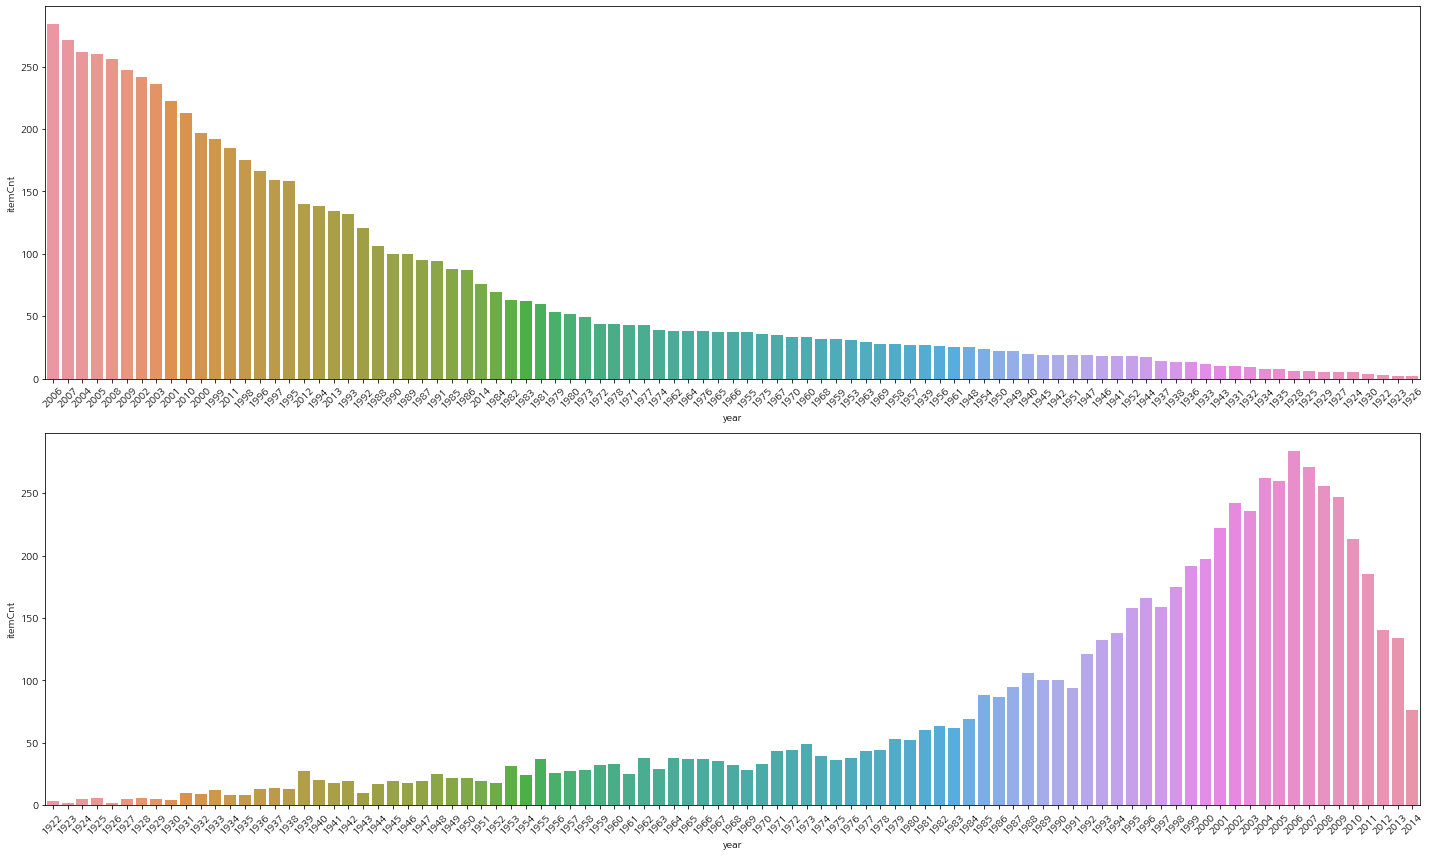

In [94]:
year_group_df_reset = year_group_df.reset_index(drop=True)
year_group_df_reset['year']=year_group_df_reset['year'].astype(str)

fig, axes = plt.subplots(2,1,figsize=(20,12))
sns.barplot(data=year_group_df_reset, x='year', y='itemCnt', ax=axes[0])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].set_title("영화 개봉을 많이 한 연도부터 내림차순")

year_group_df_sort_year = year_group_df.sort_values('year')
sns.barplot(data=year_group_df_sort_year, x='year', y='itemCnt', ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].set_title("연도별 영화 개봉 개수")

plt.tight_layout()
plt.show()

# Writer

In [25]:
display(writer_data.info())
print('\nwriter nunique : ', writer_data['writer'].nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11306 entries, 0 to 11305
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   item    11306 non-null  int64 
 1   writer  11306 non-null  object
dtypes: int64(1), object(1)
memory usage: 176.8+ KB


None


writer nunique :  2989


In [13]:
display(writer_data.head())
print("writer에 nm이 아닌 경우 : ",len(writer_data[~writer_data['writer'].str.contains('nm')]))

,item,writer
0,1237,nm0000005
1,5147,nm0000005
2,7327,nm0000005
3,2068,nm0000005
4,7396,nm0000005


writer에 nm이 아닌 경우 :  0


In [21]:
writer_data['writer'].nunique()

2989

In [52]:
writer_group_df = writer_data.groupby('writer')['item'].count().reset_index()
writer_group_df = writer_group_df.rename(columns={"item":"itemCnt"})
writer_group_df['itemRatioPercent'] = writer_group_df['itemCnt']/(writer_group_df['itemCnt'].sum()) * 100
writer_group_df.sort_values('itemCnt', ascending=False)

,writer,itemCnt,itemRatioPercent
11,nm0000095,47,0.415708
96,nm0000636,35,0.309570
28,nm0000175,32,0.283036
1287,nm0372942,30,0.265346
14,nm0000108,29,0.256501
...,...,...,...
1407,nm0414893,2,0.017690
1405,nm0414448,2,0.017690
1403,nm0414117,2,0.017690
1402,nm0414047,2,0.017690


# title.tsv

## title에서 연도 제거 전 후 비교

In [29]:
display(title_data.info())
print("\ntitle nunique : ",title_data['title'].nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6807 entries, 0 to 6806
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   item    6807 non-null   int64 
 1   title   6807 non-null   object
dtypes: int64(1), object(1)
memory usage: 106.5+ KB


None


title nunique :  6806


In [31]:
title_data[title_data['title'].duplicated(keep=False)]

,item,title
349,34048,War of the Worlds (2005)
1926,64997,War of the Worlds (2005)


In [20]:
import re
print("before sub title-year : \n", title_data['title'])
print("before sub title-year duplicated #: ", title_data['title'].duplicated().sum())
k = title_data['title'].apply(lambda x : re.sub(r" \([0-9]+\)", "", x))
print()
print('-----------after---------------')
print()
print("after sub title-year : \n", k)
print("after sub title-year duplicated #: ", k.duplicated().sum())

before sub title-year : 
 0                        Shawshank Redemption, The (1994)
1                                      Matrix, The (1999)
2                                       Fight Club (1999)
3                                     Pulp Fiction (1994)
4                                     Forrest Gump (1994)
                              ...                        
6802    American Pie Presents: The Book of Love (Ameri...
6803                                Need for Speed (2014)
6804                                        Taxi 3 (2003)
6805                      Porky's II: The Next Day (1983)
6806                           Girl Next Door, The (1999)
Name: title, Length: 6807, dtype: object
before sub title-year duplicated #:  1

-----------after---------------

after sub title-year : 
 0                               Shawshank Redemption, The
1                                             Matrix, The
2                                              Fight Club
3                      

In [21]:
print(k[k.duplicated(keep=False)])
a = k[k.duplicated(keep="first")].values
for i in a:
    display(title_data[title_data['title'].str.contains(i)])

25                 Gladiator
77             Casino Royale
95                   Titanic
107                   Batman
133                    Crash
                ...         
6745    Yours, Mine and Ours
6749                  Wanted
6781                    Taxi
6796              Underworld
6806     Girl Next Door, The
Name: title, Length: 369, dtype: object


,item,title
501,1032,Alice in Wonderland (1951)
704,74789,Alice in Wonderland (2010)
6643,80748,Alice in Wonderland (1933)


,item,title
340,41569,King Kong (2005)
744,2366,King Kong (1933)
3783,2367,King Kong (1976)


,item,title
485,1267,"Manchurian Candidate, The (1962)"
898,8781,"Manchurian Candidate, The (2004)"


,item,title
982,2664,Invasion of the Body Snatchers (1956)
1101,7001,Invasion of the Body Snatchers (1978)


,item,title
135,1073,Willy Wonka & the Chocolate Factory (1971)
239,30793,Charlie and the Chocolate Factory (2005)
282,4014,Chocolat (2000)
914,265,Like Water for Chocolate (Como agua para choco...
1111,4703,Chocolat (1988)
2105,66130,Chocolate (2008)
2759,321,Strawberry and Chocolate (Fresa y chocolate) (...
3262,2774,Better Than Chocolate (1999)
4224,50796,Blood and Chocolate (2007)


,item,title
169,4262,Scarface (1983)
1202,25788,Scarface (1932)


,item,title
472,2455,"Fly, The (1986)"
1222,2454,"Fly, The (1958)"
4212,2453,"Boy Who Could Fly, The (1986)"


,item,title
581,5388,Insomnia (2002)
1233,1889,Insomnia (1997)


,item,title
1041,52975,Hairspray (2007)
1306,2926,Hairspray (1988)


,item,title
751,6331,Spellbound (2002)
1348,931,Spellbound (1945)


,item,title
290,54997,3:10 to Yuma (2007)
1484,5300,3:10 to Yuma (1957)


,item,title
402,82459,True Grit (2010)
1501,3494,True Grit (1969)


,item,title
850,3271,Of Mice and Men (1992)
1580,4178,Of Mice and Men (1939)


,item,title
1056,2183,"Man Who Knew Too Much, The (1956)"
1634,2212,"Man Who Knew Too Much, The (1934)"


,item,title
95,1721,Titanic (1997)
1647,3404,Titanic (1953)


,item,title
1691,8341,Oliver Twist (1948)
1821,37736,Oliver Twist (2005)


,item,title
349,34048,War of the Worlds (2005)
932,2662,"War of the Worlds, The (1953)"
1926,64997,War of the Worlds (2005)


,item,title
741,261,Little Women (1994)
2074,4921,Little Women (1933)
2634,7054,Little Women (1949)


,item,title
1797,2779,Heaven Can Wait (1978)
2157,25891,Heaven Can Wait (1943)


,item,title
629,53519,Death Proof (2007)
919,5446,Rabbit-Proof Fence (2002)
1199,36527,Proof (2005)
2167,7020,Proof (1991)
3118,3998,Proof of Life (2000)


,item,title
797,1411,Hamlet (1996)
2198,3598,Hamlet (2000)
2281,1941,Hamlet (1948)
3083,3723,Hamlet (1990)
3229,61246,Hamlet 2 (2008)


,item,title
797,1411,Hamlet (1996)
2198,3598,Hamlet (2000)
2281,1941,Hamlet (1948)
3083,3723,Hamlet (1990)
3229,61246,Hamlet 2 (2008)


,item,title
1625,85438,Jane Eyre (2011)
2403,6983,Jane Eyre (1944)
3219,87308,Jane Eyre (2006)
5198,613,Jane Eyre (1996)


,item,title
1925,6974,"Freshman, The (1990)"
2574,25752,"Freshman, The (1925)"


,item,title
2521,5974,"Thief of Bagdad, The (1940)"
2632,7302,"Thief of Bagdad, The (1924)"


,item,title
741,261,Little Women (1994)
2074,4921,Little Women (1933)
2634,7054,Little Women (1949)


,item,title
995,3022,"General, The (1926)"
2662,2425,"General, The (1998)"


,item,title
1637,41,Richard III (1995)
2710,7338,Richard III (1955)


,item,title
1601,25777,Monkey Business (1931)
2733,5397,Monkey Business (1952)


,item,title
1749,2633,"Mummy, The (1932)"
2935,2617,"Mummy, The (1999)"
4214,2634,"Mummy, The (1959)"


,item,title
1584,7579,Pride and Prejudice (1940)
2979,7669,Pride and Prejudice (1995)


,item,title
797,1411,Hamlet (1996)
2198,3598,Hamlet (2000)
2281,1941,Hamlet (1948)
3083,3723,Hamlet (1990)
3229,61246,Hamlet 2 (2008)


,item,title
2333,4174,Avalon (1990)
3150,6790,Avalon (2001)


,item,title
671,1982,Halloween (1978)
3156,54785,Halloween (2007)
3884,1983,Halloween II (1981)
3934,2107,Halloween H20: 20 Years Later (Halloween 7: Th...
4151,1985,Halloween 4: The Return of Michael Myers (1988)
4159,891,Halloween: The Curse of Michael Myers (Hallowe...
4223,1984,Halloween III: Season of the Witch (1982)
4269,1986,Halloween 5: The Revenge of Michael Myers (1989)


,item,title
2389,5383,"Hound of the Baskervilles, The (1959)"
3191,8404,"Hound of the Baskervilles, The (1939)"


,item,title
1389,28,Persuasion (1995)
2729,4046,Friendly Persuasion (1956)
3193,74508,Persuasion (2007)
5892,34540,Pretty Persuasion (2005)


,item,title
1625,85438,Jane Eyre (2011)
2403,6983,Jane Eyre (1944)
3219,87308,Jane Eyre (2006)
5198,613,Jane Eyre (1996)


,item,title
1755,2612,Mildred Pierce (1945)
3274,86487,Mildred Pierce (2011)


,item,title
0,318,"Shawshank Redemption, The (1994)"
158,1610,"Hunt for Red October, The (1990)"
546,2427,"Thin Red Line, The (1998)"
655,306,Three Colors: Red (Trois couleurs: Rouge) (1994)
698,2686,"Red Violin, The (Violon rouge, Le) (1998)"
852,81229,Red (2010)
1027,1280,Raise the Red Lantern (Da hong deng long gao g...
1174,35957,Red Eye (2005)
1544,93838,The Raid: Redemption (2011)
1583,7070,Red River (1948)


,item,title
3192,33164,House of Wax (2005)
3280,6629,House of Wax (1953)


,item,title
2687,3621,Possession (1981)
3283,5527,Possession (2002)


,item,title
630,497,Much Ado About Nothing (1993)
3339,103027,Much Ado About Nothing (2012)


,item,title
1397,906,Gaslight (1944)
3360,25852,Gaslight (1940)


,item,title
3120,8580,Into the Woods (1991)
3368,118997,Into the Woods (2014)


,item,title
2118,8264,Grey Gardens (1975)
3397,72367,Grey Gardens (2009)


,item,title
596,7387,Dawn of the Dead (1978)
3440,7360,Dawn of the Dead (2004)


,item,title
2029,7079,"Hunchback of Notre Dame, The (1939)"
3487,783,"Hunchback of Notre Dame, The (1996)"


,item,title
368,2529,Planet of the Apes (1968)
2967,88744,Rise of the Planet of the Apes (2011)
3057,112623,Dawn of the Planet of the Apes (2014)
3070,2533,Escape from the Planet of the Apes (1971)
3492,4643,Planet of the Apes (2001)
3853,2530,Beneath the Planet of the Apes (1970)
3921,2531,Battle for the Planet of the Apes (1973)
3960,2532,Conquest of the Planet of the Apes (1972)


,item,title
1570,2136,"Nutty Professor, The (1963)"
3513,788,"Nutty Professor, The (1996)"


,item,title
490,2078,"Jungle Book, The (1967)"
3521,362,"Jungle Book, The (1994)"


,item,title
2558,6516,Anastasia (1956)
3542,1688,Anastasia (1997)


,item,title
1839,3224,Woman in the Dunes (Suna no onna) (1964)
3329,111235,Jodorowsky's Dune (2013)
3448,2021,Dune (1984)
3565,7842,Dune (2000)
3658,7841,Children of Dune (2003)


,item,title
1037,3959,"Time Machine, The (1960)"
3593,5171,"Time Machine, The (2002)"


,item,title
1008,1013,"Parent Trap, The (1961)"
3602,2059,"Parent Trap, The (1998)"


,item,title
579,2010,Metropolis (1927)
3635,5072,Metropolis (2001)


,item,title
620,2087,Peter Pan (1953)
3660,7164,Peter Pan (2003)
4075,74089,Peter Pan (1960)


,item,title
147,1219,Psycho (1960)
322,3535,American Psycho (2000)
3669,2389,Psycho (1998)
4191,2902,Psycho II (1983)
4686,97306,Seven Psychopaths (2012)


,item,title
1770,2550,"Haunting, The (1963)"
3688,2719,"Haunting, The (1999)"


,item,title
22,33794,Batman Begins (2005)
107,592,Batman (1989)
455,1377,Batman Returns (1992)
3112,79274,Batman: Under the Red Hood (2010)
3352,80469,Superman/Batman: Apocalypse (2010)
3443,153,Batman Forever (1995)
3600,1562,Batman & Robin (1997)
3673,3213,Batman: Mask of the Phantasm (1993)
3696,26152,Batman (1966)
3754,60979,Batman: Gotham Knight (2008)


,item,title
651,1253,"Day the Earth Stood Still, The (1951)"
3711,64497,"Day the Earth Stood Still, The (2008)"


,item,title
1679,2346,"Stepford Wives, The (1975)"
3718,8373,"Stepford Wives, The (2004)"


,item,title
1068,2459,"Texas Chainsaw Massacre, The (1974)"
3724,6880,"Texas Chainsaw Massacre, The (2003)"


,item,title
3678,1327,"Amityville Horror, The (1979)"
3727,33085,"Amityville Horror, The (2005)"


,item,title
3690,5540,Clash of the Titans (1981)
3731,76175,Clash of the Titans (2010)


,item,title
1636,952,Around the World in 80 Days (1956)
3779,8526,Around the World in 80 Days (2004)


,item,title
340,41569,King Kong (2005)
744,2366,King Kong (1933)
3783,2367,King Kong (1976)


,item,title
1102,6593,Freaky Friday (2003)
3785,2014,Freaky Friday (1977)


,item,title
2365,2519,House on Haunted Hill (1959)
3794,2995,House on Haunted Hill (1999)


,item,title
540,968,Night of the Living Dead (1968)
3795,8225,Night of the Living Dead (1990)


,item,title
1995,6239,Journey to the Center of the Earth (1959)
3817,60514,Journey to the Center of the Earth (2008)


,item,title
2461,4480,"Blob, The (1988)"
3832,1334,"Blob, The (1958)"


,item,title
531,2420,"Karate Kid, The (1984)"
1284,3310,"Kid, The (1921)"
2367,8494,"Cincinnati Kid, The (1965)"
3861,3784,"Kid, The (2000)"
4357,79224,"Karate Kid, The (2010)"
6198,33126,"Frisco Kid, The (1979)"
6311,55261,"Heartbreak Kid, The (2007)"
6723,502,"Next Karate Kid, The (1994)"


,item,title
822,2137,Charlotte's Web (1973)
3863,49647,Charlotte's Web (2006)


,item,title
1398,8492,"Christmas Carol, A (Scrooge) (1951)"
3251,26502,"Christmas Carol, A (1984)"
3880,72294,"Christmas Carol, A (2009)"
6204,1099,"Christmas Carol, A (1938)"


,item,title
747,1350,"Omen, The (1976)"
3922,45662,"Omen, The (2006)"


,item,title
2419,5569,"Last House on the Left, The (1972)"
3989,68941,"Last House on the Left, The (2009)"


,item,title
1046,4754,"Wicker Man, The (1973)"
4048,47810,"Wicker Man, The (2006)"


,item,title
2818,25835,Dead End (1937)
4054,27584,Dead End (2003)


,item,title
3716,8501,"Hitcher, The (1986)"
4059,50445,"Hitcher, The (2007)"


,item,title
620,2087,Peter Pan (1953)
3660,7164,Peter Pan (2003)
4075,74089,Peter Pan (1960)


,item,title
2036,7713,Cat People (1942)
4097,1346,Cat People (1982)


,item,title
2138,2553,Village of the Damned (1960)
4139,332,Village of the Damned (1995)


,item,title
3606,1974,Friday the 13th (1980)
3931,1975,Friday the 13th Part 2 (1981)
4063,1977,Friday the 13th Part IV: The Final Chapter (1984)
4101,1976,Friday the 13th Part 3: 3D (1982)
4110,1979,Friday the 13th Part VI: Jason Lives (1986)
4147,66783,Friday the 13th (2009)
4235,1978,Friday the 13th Part V: A New Beginning (1985)
4262,1980,Friday the 13th Part VII: The New Blood (1988)
4293,1981,Friday the 13th Part VIII: Jason Takes Manhatt...


,item,title
1749,2633,"Mummy, The (1932)"
2935,2617,"Mummy, The (1999)"
4214,2634,"Mummy, The (1959)"


,item,title
2343,8521,Dr. Jekyll and Mr. Hyde (1931)
4231,7208,Dr. Jekyll and Mr. Hyde (1941)


,item,title
2846,2227,"Lodger: A Story of the London Fog, The (1927)"
3153,1128,"Fog, The (1980)"
4273,39400,"Fog, The (2005)"


,item,title
320,33660,Cinderella Man (2005)
539,1022,Cinderella (1950)
2970,2125,Ever After: A Cinderella Story (1998)
4287,63239,Cinderella (1997)
6083,8643,"Cinderella Story, A (2004)"


,item,title
4070,2429,Mighty Joe Young (1998)
4292,2430,Mighty Joe Young (1949)


,item,title
531,2420,"Karate Kid, The (1984)"
4357,79224,"Karate Kid, The (2010)"
6723,502,"Next Karate Kid, The (1994)"


,item,title
257,4308,Moulin Rouge (2001)
4455,8731,Moulin Rouge (1952)


,item,title
3060,27741,"Twilight Samurai, The (Tasogare Seibei) (2002)"
3559,63992,Twilight (2008)
3709,72407,"Twilight Saga: New Moon, The (2009)"
3806,26492,Twilight Zone: The Movie (1983)
4476,1791,Twilight (1998)
6608,78772,"Twilight Saga: Eclipse, The (2010)"
6610,91104,"Twilight Saga: Breaking Dawn - Part 1, The (2011)"
6612,98203,"Twilight Saga: Breaking Dawn - Part 2, The (2012)"


,item,title
25,3578,Gladiator (2000)
4522,8132,Gladiator (1992)


,item,title
1182,2764,"Thomas Crown Affair, The (1968)"
4531,2763,"Thomas Crown Affair, The (1999)"


,item,title
1873,26462,Bad Boys (1983)
4538,145,Bad Boys (1995)
4627,6548,Bad Boys II (2003)


,item,title
955,1344,Cape Fear (1962)
4542,1343,Cape Fear (1991)


,item,title
1347,31923,"Three Musketeers, The (1973)"
4553,552,"Three Musketeers, The (1993)"
6398,90403,"Three Musketeers, The (2011)"


,item,title
4045,59604,"Girl Next Door, The (2007)"
4626,7346,"Girl Next Door, The (2004)"
6806,8130,"Girl Next Door, The (1999)"


,item,title
2310,25755,"Phantom of the Opera, The (1925)"
4630,30816,"Phantom of the Opera, The (2004)"


,item,title
1126,934,Father of the Bride (1950)
4639,6944,Father of the Bride (1991)
5454,5,Father of the Bride Part II (1995)


,item,title
1340,5602,"Ladykillers, The (1955)"
4688,7367,"Ladykillers, The (2004)"


,item,title
1525,4220,"Longest Yard, The (1974)"
4709,33646,"Longest Yard, The (2005)"


,item,title
2533,5001,Sahara (1943)
4719,32596,Sahara (2005)


,item,title
2270,3729,Shaft (1971)
4726,3744,Shaft (2000)


,item,title
4161,4636,"Punisher, The (1989)"
4739,7439,"Punisher, The (2004)"


,item,title
1542,3726,Assault on Precinct 13 (1976)
4743,31420,Assault on Precinct 13 (2005)


,item,title
605,2300,"Producers, The (1968)"
4762,42002,"Producers, The (2005)"


,item,title
187,2916,Total Recall (1990)
4775,95875,Total Recall (2012)


,item,title
3300,5588,"Hills Have Eyes, The (1977)"
4787,44397,"Hills Have Eyes, The (2006)"


,item,title
2372,31934,"Four Feathers, The (1939)"
4900,5611,"Four Feathers, The (2002)"


,item,title
379,2288,"Thing, The (1982)"
1738,6636,"Sure Thing, The (1985)"
4931,90345,"Thing, The (2011)"
6086,5296,"Sweetest Thing, The (2002)"


,item,title
4919,7379,"Alamo, The (2004)"
4947,4042,"Alamo, The (1960)"


,item,title
1394,43921,Running Scared (2006)
4985,2457,Running Scared (1986)


,item,title
1541,60943,Frozen River (2008)
3016,106696,Frozen (2013)
4991,75395,Frozen (2010)
6237,31785,Frozen Land (Paha maa) (2005)


,item,title
2068,7223,D.O.A. (1950)
4998,4496,D.O.A. (1988)


,item,title
1201,5267,"Rookie, The (2002)"
5026,6812,"Rookie, The (1990)"


,item,title
1883,3947,Get Carter (1971)
5037,3946,Get Carter (2000)


,item,title
666,1347,"Nightmare on Elm Street, A (1984)"
5047,77798,"Nightmare on Elm Street, A (2010)"


,item,title
245,6378,"Italian Job, The (2003)"
5061,6893,"Italian Job, The (1969)"


,item,title
309,33679,Mr. & Mrs. Smith (2005)
5091,2205,Mr. & Mrs. Smith (1941)


,item,title
19,7361,Eternal Sunshine of the Spotless Mind (2004)
82,46578,Little Miss Sunshine (2006)
628,52328,Sunshine (2007)
3069,67267,Sunshine Cleaning (2008)
5108,3720,Sunshine (1999)
5155,5447,Sunshine State (2002)


,item,title
1234,1277,Cyrano de Bergerac (1990)
5145,44100,Cyrano de Bergerac (1950)


,item,title
4604,1801,"Man in the Iron Mask, The (1998)"
5159,53919,"Man in the Iron Mask, The (1939)"


,item,title
2916,5418,"Bourne Identity, The (2002)"
5166,26614,"Bourne Identity, The (1988)"


,item,title
4332,73,"Misérables, Les (1995)"
5182,1873,"Misérables, Les (1998)"
5482,99149,"Misérables, Les (2012)"


,item,title
143,1203,12 Angry Men (1957)
5197,77846,12 Angry Men (1997)


,item,title
1625,85438,Jane Eyre (2011)
2403,6983,Jane Eyre (1944)
3219,87308,Jane Eyre (2006)
5198,613,Jane Eyre (1996)


,item,title
3137,96606,Samsara (2011)
5221,8485,Samsara (2001)


,item,title
1487,947,My Man Godfrey (1936)
5229,3096,My Man Godfrey (1957)


,item,title
4973,26322,Gone in 60 Seconds (1974)
5241,3717,Gone in 60 Seconds (2000)


,item,title
133,33166,Crash (2004)
227,34162,Wedding Crashers (2005)
5258,1483,Crash (1996)


,item,title
5164,6519,Fun with Dick and Jane (1977)
5261,42011,Fun with Dick and Jane (2005)


,item,title
841,2729,Lolita (1962)
5264,2025,Lolita (1997)


,item,title
1130,3461,Lord of the Flies (1963)
5293,4951,Lord of the Flies (1990)


,item,title
2808,25941,Letter from an Unknown Woman (1948)
4327,84601,Unknown (2011)
4475,6641,Code Unknown (Code inconnu: Récit incomplet de...
5323,51037,Unknown (2006)
6062,26560,"Unknown Soldier, The (Tuntematon sotilas) (1985)"
6225,26007,"Unknown Soldier, The (Tuntematon sotilas) (1955)"


,item,title
1612,946,To Be or Not to Be (1942)
5370,26491,To Be or Not to Be (1983)


,item,title
1741,26425,"In-Laws, The (1979)"
5401,6374,"In-Laws, The (2003)"


,item,title
5326,57353,Flawless (2007)
5404,3115,Flawless (1999)


,item,title
781,2398,Miracle on 34th Street (1947)
5433,277,Miracle on 34th Street (1994)


,item,title
3879,55553,Black Sheep (2006)
5458,88,Black Sheep (1996)


,item,title
718,3034,Robin Hood (1973)
961,940,"Adventures of Robin Hood, The (1938)"
1437,1361,Paradise Lost: The Child Murders at Robin Hood...
4524,520,Robin Hood: Men in Tights (1993)
4550,1027,Robin Hood: Prince of Thieves (1991)
5471,77866,Robin Hood (2010)


,item,title
2265,7826,"Secret Life of Walter Mitty, The (1947)"
5473,106918,"Secret Life of Walter Mitty, The (2013)"


,item,title
1549,25923,Great Expectations (1946)
5474,1735,Great Expectations (1998)


,item,title
4332,73,"Misérables, Les (1995)"
5182,1873,"Misérables, Les (1998)"
5482,99149,"Misérables, Les (2012)"


,item,title
3204,7178,"Great Gatsby, The (1974)"
5491,102407,"Great Gatsby, The (2013)"


,item,title
1840,4191,Alfie (1966)
5500,8948,Alfie (2004)


,item,title
799,6662,"Pink Panther, The (1963)"
851,1125,"Return of the Pink Panther, The (1975)"
5547,43836,"Pink Panther, The (2006)"


,item,title
1914,1942,All the King's Men (1949)
5605,48326,All the King's Men (2006)


,item,title
2773,7092,Anna Karenina (1935)
5647,97936,Anna Karenina (2012)


,item,title
5416,7019,Project X (1987)
5651,93270,Project X (2012)


,item,title
1441,3524,Arthur (1981)
4069,50162,Arthur and the Invisibles (2007)
4697,8640,King Arthur (2004)
5653,86293,Arthur (2011)
5955,91414,Arthur Christmas (2011)


,item,title
1205,5120,Sleuth (1972)
5668,55278,Sleuth (2007)


,item,title
4573,1587,Conan the Barbarian (1982)
5693,89190,Conan the Barbarian (2011)


,item,title
1956,3008,Last Night (1998)
2318,2262,About Last Night... (1986)
5702,83302,Last Night (2010)


,item,title
757,838,Emma (1996)
5752,84847,Emma (2009)
6467,6493,Alex and Emma (2003)


,item,title
5284,7161,Cheaper by the Dozen (2003)
5756,7395,Cheaper by the Dozen (1950)
6764,42009,Cheaper by the Dozen 2 (2005)


,item,title
4511,736,Twister (1996)
5762,7781,Twister (1990)


,item,title
1753,2867,Fright Night (1985)
5769,89030,Fright Night (2011)


,item,title
1611,7728,"Postman Always Rings Twice, The (1946)"
5774,3529,"Postman Always Rings Twice, The (1981)"


,item,title
550,1345,Carrie (1976)
4051,73168,Carriers (2009)
5775,25971,Carrie (1952)


,item,title
501,1032,Alice in Wonderland (1951)
704,74789,Alice in Wonderland (2010)
1651,8838,Alice Doesn't Live Here Anymore (1974)
2595,26631,Alice (Neco z Alenky) (1988)
4113,72982,Alice (2009)
5350,77843,"Disappearance of Alice Creed, The (2009)"
5777,4392,Alice (1990)
6221,117881,Still Alice (2014)
6471,26199,Alice's Restaurant (1969)
6643,80748,Alice in Wonderland (1933)


,item,title
1864,25856,Wuthering Heights (1939)
5795,7179,Wuthering Heights (1992)


,item,title
2102,7708,Bedazzled (1967)
5810,3968,Bedazzled (2000)


,item,title
4858,48520,Employee of the Month (2006)
5888,31445,Employee of the Month (2004)


,item,title
77,49272,Casino Royale (2006)
5926,5796,Casino Royale (1967)


,item,title
762,915,Sabrina (1954)
6003,7,Sabrina (1995)


,item,title
294,2395,Rushmore (1998)
479,2273,Rush Hour (1998)
959,3629,"Gold Rush, The (1925)"
1968,8158,Rush (1991)
4875,96417,Premium Rush (2012)
5150,4772,Dinner Rush (2000)
5470,55872,August Rush (2007)
5730,4701,Rush Hour 2 (2001)
5741,1457,Fools Rush In (1997)
6004,104913,Rush (2013)


,item,title
2239,25825,Fury (1936)
2353,3539,"Filth and the Fury, The (2000)"
4857,4440,"Big Boss, The (Fists of Fury) (Tang shan da xi..."
4862,4438,"Fist of Fury (Chinese Connection, The) (Jing w..."
5630,54732,Balls of Fury (2007)
6016,115210,Fury (2014)


,item,title
367,2985,RoboCop (1987)
3661,2986,RoboCop 2 (1990)
3833,519,RoboCop 3 (1993)
6034,108945,RoboCop (2014)


,item,title
4360,85020,"Mechanic, The (2011)"
6122,5692,"Mechanic, The (1972)"


,item,title
1398,8492,"Christmas Carol, A (Scrooge) (1951)"
3251,26502,"Christmas Carol, A (1984)"
3880,72294,"Christmas Carol, A (2009)"
6204,1099,"Christmas Carol, A (1938)"


,item,title
1529,1931,Mutiny on the Bounty (1935)
6206,26085,Mutiny on the Bounty (1962)


,item,title
1649,2363,Godzilla (Gojira) (1954)
3579,1882,Godzilla (1998)
3936,3864,Godzilla 2000 (Gojira ni-sen mireniamu) (1999)
4164,5640,"Godzilla, King of the Monsters! (Kaijû-ô Gojir..."
5006,5638,Godzilla vs. Mothra (Mosura tai Gojira) (1964)
6217,111364,Godzilla (2014)


/tmp/ipykernel_104082/2600120309.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(i)])


,item,title


,item,title
1287,32598,Fever Pitch (2005)
6239,2962,Fever Pitch (1997)


,item,title
1347,31923,"Three Musketeers, The (1973)"
4553,552,"Three Musketeers, The (1993)"
6398,90403,"Three Musketeers, The (2011)"


,item,title
779,930,Notorious (1946)
3250,45635,"Notorious Bettie Page, The (2005)"
3334,7879,Notorious C.H.O. (2002)
6430,65810,Notorious (2009)


,item,title
2247,299,Priest (1994)
2536,7301,Diary of a Country Priest (Journal d'un curé d...
6438,86835,Priest (2011)


,item,title
240,73017,Sherlock Holmes (2009)
2591,6581,"Private Life of Sherlock Holmes, The (1970)"
3217,8401,"Adventures of Sherlock Holmes, The (1939)"
5171,91542,Sherlock Holmes: A Game of Shadows (2011)
5742,2414,Young Sherlock Holmes (1985)
6532,89780,Sherlock Holmes (2010)


,item,title
922,53956,Death at a Funeral (2007)
6542,77191,Death at a Funeral (2010)


,item,title
2093,1236,Trust (1990)
6594,87079,Trust (2010)


,item,title
182,6,Heat (1995)
452,1285,Heathers (1989)
897,1950,In the Heat of the Night (1967)
1109,2917,Body Heat (1981)
1352,8491,White Heat (1949)
1547,5017,"Big Heat, The (1953)"
4972,4531,Red Heat (1988)
5928,103372,"Heat, The (2013)"
6597,73608,Heat (1972)


,item,title
5710,90914,"Devil's Double, The (2011)"
6520,105835,"Double, The (2013)"
6604,90738,"Double, The (2011)"


,item,title
2933,89745,"Avengers, The (2012)"
6619,2153,"Avengers, The (1998)"


,item,title
4898,7048,Nothing to Lose (1997)
6623,875,Nothing to Lose (1994)


,item,title
501,1032,Alice in Wonderland (1951)
704,74789,Alice in Wonderland (2010)
6643,80748,Alice in Wonderland (1933)


,item,title
1294,7560,Fail-Safe (1964)
1829,8235,Safety Last! (1923)
2491,190,Safe (1995)
5187,95088,Safety Not Guaranteed (2012)
6192,100527,Safe Haven (2013)
6375,92507,Safe House (2012)
6698,94405,Safe (2012)


,item,title
6647,26198,"Yours, Mine and Ours (1968)"
6745,40962,"Yours, Mine and Ours (2005)"


,item,title
761,60072,Wanted (2008)
2250,60382,Roman Polanski: Wanted and Desired (2008)
5070,3812,Everything You Always Wanted to Know About Sex...
6332,112940,"Most Wanted Man, A (2014)"
6695,95105,Madagascar 3: Europe's Most Wanted (2012)
6749,71460,Wanted (2009)


,item,title
109,111,Taxi Driver (1976)
1917,58191,Taxi to the Dark Side (2007)
5984,8604,Taxi (1998)
6248,48231,Taxidermia (2006)
6781,8912,Taxi (2004)
6784,27193,Taxi 2 (2000)
6804,8605,Taxi 3 (2003)


,item,title
2966,6754,Underworld (2003)
3506,42738,Underworld: Evolution (2006)
3651,65682,Underworld: Rise of the Lycans (2009)
5604,91974,Underworld: Awakening (2012)
6796,1430,Underworld (1996)


,item,title
4045,59604,"Girl Next Door, The (2007)"
4626,7346,"Girl Next Door, The (2004)"
6806,8130,"Girl Next Door, The (1999)"


In [73]:
the_df = title_data[title_data['title'].str.contains(", The \(")]
print(", The (연도) 가 들어가는 title 개수 : ", the_df.size)
the_title = the_df['title'].apply(lambda x : re.sub(r", The \([0-9]+\)", "", x)).unique()

for tit in the_title:
    display(title_data[title_data['title'].str.contains(tit)])

, The (연도) 가 들어가는 title 개수 :  2822


,item,title
0,318,"Shawshank Redemption, The (1994)"


,item,title
1,2571,"Matrix, The (1999)"
2920,6365,"Matrix Reloaded, The (2003)"
3421,6934,"Matrix Revolutions, The (2003)"


,item,title
5,4993,"Lord of the Rings: The Fellowship of the Ring,..."


,item,title
6,7153,"Lord of the Rings: The Return of the King, The..."


,item,title
7,5952,"Lord of the Rings: The Two Towers, The (2002)"


,item,title
8,593,"Silence of the Lambs, The (1991)"


,item,title
11,58559,"Dark Knight, The (2008)"
281,91529,"Dark Knight Rises, The (2012)"
6524,99813,"Batman: The Dark Knight Returns, Part 2 (2013)"
6525,98124,"Batman: The Dark Knight Returns, Part 1 (2012)"


,item,title
13,50,"Usual Suspects, The (1995)"


,item,title
14,858,"Godfather, The (1972)"
53,1221,"Godfather: Part II, The (1974)"
423,2023,"Godfather: Part III, The (1990)"
1268,8607,Tokyo Godfathers (2003)


,item,title
18,2762,"Sixth Sense, The (1999)"


,item,title
34,8961,"Incredibles, The (2004)"


,item,title
42,48516,"Departed, The (2006)"


,item,title
52,1197,"Princess Bride, The (1987)"


,item,title
53,1221,"Godfather: Part II, The (1974)"
423,2023,"Godfather: Part III, The (1990)"


,item,title
37,589,Terminator 2: Judgment Day (1991)
58,1240,"Terminator, The (1984)"
3436,6537,Terminator 3: Rise of the Machines (2003)
3498,68791,Terminator Salvation (2009)


,item,title
61,1682,"Truman Show, The (1998)"


,item,title
64,364,"Lion King, The (1994)"
5057,27619,"Lion King 1½, The (2004)"
6717,26999,"Lion King II: Simba's Pride, The (1998)"


,item,title
67,1527,"Fifth Element, The (1997)"


,item,title
72,1258,"Shining, The (1980)"


,item,title
78,457,"Fugitive, The (1993)"
2017,8044,I Am a Fugitive from a Chain Gang (1932)


,item,title
83,48780,"Prestige, The (2006)"


,item,title
85,1732,"Big Lebowski, The (1998)"


,item,title
93,54286,"Bourne Ultimatum, The (2007)"


,item,title
94,8665,"Bourne Supremacy, The (2004)"


,item,title
137,1968,"Breakfast Club, The (1985)"


,item,title
142,5995,"Pianist, The (2002)"
5291,2691,"Legend of 1900, The (a.k.a. The Legend of the ..."


,item,title
148,35836,"40-Year-Old Virgin, The (2005)"


,item,title
153,919,"Wizard of Oz, The (1939)"


,item,title
158,1610,"Hunt for Red October, The (1990)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
173,69122,"Hangover, The (2009)"
1274,86911,"Hangover Part II, The (2011)"
4924,102686,"Hangover Part III, The (2013)"


,item,title
174,551,"Nightmare Before Christmas, The (1993)"


,item,title
177,1220,"Blues Brothers, The (1980)"
4766,1772,Blues Brothers 2000 (1998)


,item,title
184,4979,"Royal Tenenbaums, The (2001)"


,item,title
189,2194,"Untouchables, The (1987)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
202,47610,"Illusionist, The (2006)"
1739,81018,"Illusionist, The (L'illusionniste) (2010)"


,item,title
206,367,"Mask, The (1994)"
457,2006,"Mask of Zorro, The (1998)"
1330,8880,Mask (1985)
3590,37857,MirrorMask (2005)
3673,3213,Batman: Mask of the Phantasm (1993)
4092,54910,Behind the Mask: The Rise of Leslie Vernon (2006)
4604,1801,"Man in the Iron Mask, The (1998)"
5159,53919,"Man in the Iron Mask, The (1939)"
6641,2609,"King of Masks, The (Bian Lian) (1996)"


,item,title
218,81845,"King's Speech, The (2010)"


,item,title
222,1247,"Graduate, The (1967)"


,item,title
225,1234,"Sting, The (1973)"


,item,title
191,44555,"Lives of Others, The (Das leben der Anderen) (..."
233,4720,"Others, The (2001)"
2581,4151,"Taste of Others, The (Le goût des autres) (2000)"


,item,title
236,41566,"Chronicles of Narnia: The Lion, the Witch and ..."


,item,title
245,6378,"Italian Job, The (2003)"
5061,6893,"Italian Job, The (1969)"


,item,title
250,1262,"Great Escape, The (1963)"


,item,title
254,80463,"Social Network, The (2010)"


,item,title
262,1997,"Exorcist, The (1973)"
4015,8815,Exorcist: The Beginning (2004)
4062,1999,"Exorcist III, The (1990)"


,item,title
280,1127,"Abyss, The (1989)"
6461,90943,Into the Abyss (2011)


,item,title
281,91529,"Dark Knight Rises, The (2012)"


,item,title
303,33004,"Hitchhiker's Guide to the Galaxy, The (2005)"


,item,title
305,2081,"Little Mermaid, The (1989)"


,item,title
306,1250,"Bridge on the River Kwai, The (1957)"


,item,title
307,1035,"Sound of Music, The (1965)"


,item,title
310,54272,"Simpsons Movie, The (2007)"


,item,title
312,30812,"Aviator, The (2004)"


,item,title
313,30810,"Life Aquatic with Steve Zissou, The (2004)"


,item,title
5,4993,"Lord of the Rings: The Fellowship of the Ring,..."
6,7153,"Lord of the Rings: The Return of the King, The..."
7,5952,"Lord of the Rings: The Two Towers, The (2002)"
314,5679,"Ring, The (2002)"
831,6242,Ringu (Ring) (1998)
1500,2551,Dead Ringers (1988)
1611,7728,"Postman Always Rings Twice, The (1946)"
3410,32743,Ringu 0: Bâsudei (2000)
3540,2116,"Lord of the Rings, The (1978)"
3777,27839,"Ring Two, The (2005)"


,item,title
316,48738,"Last King of Scotland, The (2006)"


,item,title
319,1263,"Deer Hunter, The (1978)"


,item,title
321,1333,"Birds, The (1963)"
5206,95858,For the Birds (2000)


,item,title
332,913,"Maltese Falcon, The (1941)"
665,8228,"Maltese Falcon, The (a.k.a. Dangerous Female) ..."


,item,title
333,2005,"Goonies, The (1985)"


,item,title
334,3176,"Talented Mr. Ripley, The (1999)"


,item,title
345,64839,"Wrestler, The (2008)"


,item,title
361,64957,"Curious Case of Benjamin Button, The (2008)"


,item,title
365,69481,"Hurt Locker, The (2008)"


,item,title
369,1641,"Full Monty, The (1997)"


,item,title
379,2288,"Thing, The (1982)"
626,3424,Do the Right Thing (1989)
792,1805,Wild Things (1998)
869,6552,Dirty Pretty Things (2002)
1069,71745,Where the Wild Things Are (2009)
1738,6636,"Sure Thing, The (1985)"
1787,1046,Beautiful Thing (1996)
1831,2660,"Thing from Another World, The (1951)"
1929,5391,Thirteen Conversations About One Thing (a.k.a....
1987,8796,"Funny Thing Happened on the Way to the Forum, ..."


,item,title
382,2710,"Blair Witch Project, The (1999)"


,item,title
388,1408,"Last of the Mohicans, The (1992)"


,item,title
391,353,"Crow, The (1994)"
1182,2764,"Thomas Crown Affair, The (1968)"
1953,3038,"Face in the Crowd, A (1957)"
2781,25766,"Crowd, The (1928)"
4531,2763,"Thomas Crown Affair, The (1999)"
4756,839,"Crow: City of Angels, The (1996)"
6590,87522,Larry Crowne (2011)


,item,title
392,2657,"Rocky Horror Picture Show, The (1975)"


,item,title
398,2761,"Iron Giant, The (1999)"


,item,title
400,2161,"NeverEnding Story, The (1984)"
3827,2162,"NeverEnding Story II: The Next Chapter, The (1..."
4288,126,"NeverEnding Story III, The (1994)"


,item,title
401,454,"Firm, The (1993)"


,item,title
404,3006,"Insider, The (1999)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
421,36517,"Constant Gardener, The (2005)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
423,2023,"Godfather: Part III, The (1990)"


,item,title
425,47099,"Pursuit of Happyness, The (2006)"


,item,title
457,2006,"Mask of Zorro, The (1998)"


,item,title
413,8983,House of Flying Daggers (Shi mian mai fu) (2004)
472,2455,"Fly, The (1986)"
590,1120,"People vs. Larry Flynt, The (1996)"
1222,2454,"Fly, The (1958)"
1505,986,Fly Away Home (1996)
1709,5059,Little Dieter Needs to Fly (1997)
2194,5373,"Cranes Are Flying, The (Letyat zhuravli) (1957)"
2423,31702,Turtles Can Fly (Lakposhtha hâm parvaz mikonan...
2872,7394,Those Magnificent Men in Their Flying Machines...
4162,2456,"Fly II, The (1989)"


,item,title
475,1212,"Third Man, The (1949)"


,item,title
480,3868,"Naked Gun: From the Files of Police Squad!, Th..."


,item,title
482,2313,"Elephant Man, The (1980)"


,item,title
485,1267,"Manchurian Candidate, The (1962)"
898,8781,"Manchurian Candidate, The (2004)"


,item,title
487,3556,"Virgin Suicides, The (1999)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
490,2078,"Jungle Book, The (1967)"
1591,6743,Jungle Book (1942)
3521,362,"Jungle Book, The (1994)"


,item,title
492,1953,"French Connection, The (1971)"


,item,title
509,969,"African Queen, The (1951)"


,item,title
524,55269,"Darjeeling Limited, The (2007)"


,item,title
529,509,"Piano, The (1993)"
1558,5269,"Piano Teacher, The (La pianiste) (2001)"
1658,7135,Shoot the Piano Player (Tirez sur le pianiste)...


,item,title
531,2420,"Karate Kid, The (1984)"
3749,2422,"Karate Kid, Part III, The (1989)"
4357,79224,"Karate Kid, The (2010)"
4680,2421,"Karate Kid, Part II, The (1986)"
6723,502,"Next Karate Kid, The (1994)"


,item,title
538,2944,"Dirty Dozen, The (1967)"


,item,title
542,2150,"Gods Must Be Crazy, The (1980)"
5539,2151,"Gods Must Be Crazy II, The (1989)"


,item,title
546,2427,"Thin Red Line, The (1998)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
552,1183,"English Patient, The (1996)"


,item,title
560,2058,"Negotiator, The (1998)"


,item,title
565,3148,"Cider House Rules, The (1999)"


,item,title
573,6867,"Station Agent, The (2003)"


,item,title
574,2140,"Dark Crystal, The (1982)"


,item,title
489,67255,"Girl with the Dragon Tattoo, The (Män som hata..."
582,91658,"Girl with the Dragon Tattoo, The (2011)"


,item,title
590,1120,"People vs. Larry Flynt, The (1996)"


,item,title
592,1960,"Last Emperor, The (1987)"


,item,title
595,48043,"Fountain, The (2006)"
5143,7581,"Fountainhead, The (1949)"


,item,title
597,109374,"Grand Budapest Hotel, The (2014)"


,item,title
598,2109,"Jerk, The (1979)"


,item,title
604,3396,"Muppet Movie, The (1979)"


,item,title
605,2300,"Producers, The (1968)"
4762,42002,"Producers, The (2005)"


,item,title
606,3108,"Fisher King, The (1991)"


,item,title
608,81932,"Fighter, The (2010)"
4031,393,Street Fighter (1994)


,item,title
610,1094,"Crying Game, The (1992)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
623,80489,"Town, The (2010)"
1204,61729,Ghost Town (2008)
1635,25827,Mr. Deeds Goes to Town (1936)
2038,3606,On the Town (1949)
2443,6228,"Talk of the Town, The (1942)"
2453,31260,Boys Town (1938)
5161,7250,"Out of Towners, The (1970)"
5232,74791,"Town Called Panic, A (Panique au village) (2009)"
6673,69253,New in Town (2009)


,item,title
633,3755,"Perfect Storm, The (2000)"


,item,title
648,1231,"Right Stuff, The (1983)"


,item,title
649,898,"Philadelphia Story, The (1940)"


,item,title
651,1253,"Day the Earth Stood Still, The (1951)"
3711,64497,"Day the Earth Stood Still, The (2008)"


,item,title
654,4327,"Magnificent Seven, The (1960)"


,item,title
664,4881,"Man Who Wasn't There, The (2001)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
667,11,"American President, The (1995)"


,item,title
509,969,"African Queen, The (1951)"
672,47629,"Queen, The (2006)"
699,345,"Adventures of Priscilla, Queen of the Desert, ..."
2285,302,"Queen Margot (Reine Margot, La) (1994)"
2736,8256,Queen Christina (1933)
3792,5128,Queen of the Damned (2002)
5064,5319,Nine Queens (Nueve reinas) (2000)
5945,96150,"Queen of Versailles, The (2012)"
6559,7316,Confessions of a Teenage Drama Queen (2004)


,item,title
678,60040,"Incredible Hulk, The (2008)"


,item,title
679,7156,Fog of War: Eleven Lessons from the Life of Ro...


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
686,784,"Cable Guy, The (1996)"


,item,title
687,1281,"Great Dictator, The (1940)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
699,345,"Adventures of Priscilla, Queen of the Desert, ..."


,item,title
578,81562,127 Hours (2010)
703,5992,"Hours, The (2002)"
1001,7419,After Hours (1985)
5125,55895,"Desperate Hours, The (1955)"


,item,title
706,909,"Apartment, The (1960)"
2246,6789,"Apartment, The (Appartement, L') (1996)"
4088,829,Joe's Apartment (1996)
4328,6370,"Spanish Apartment, The (L'auberge espagnole) (..."


,item,title
710,1284,"Big Sleep, The (1946)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
731,616,"Aristocats, The (1970)"


,item,title
732,38886,"Squid and the Whale, The (2005)"


,item,title
733,1299,"Killing Fields, The (1984)"


,item,title
736,3468,"Hustler, The (1961)"


,item,title
737,531,"Secret Garden, The (1993)"


,item,title
738,3730,"Conversation, The (1974)"
1929,5391,Thirteen Conversations About One Thing (a.k.a....
5657,48342,Conversations with Other Women (2005)


,item,title
742,2739,"Color Purple, The (1985)"


,item,title
745,58295,"Bank Job, The (2008)"


,item,title
747,1350,"Omen, The (1976)"
3922,45662,"Omen, The (2006)"
3966,2789,Damien: Omen II (1978)
4291,2790,"Final Conflict, The (a.k.a. Omen III: The Fina..."


,item,title
296,288,Natural Born Killers (1994)
766,3098,"Natural, The (1984)"


,item,title
771,2139,"Secret of NIMH, The (1982)"


,item,title
772,1254,"Treasure of the Sierra Madre, The (1948)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
787,1635,"Ice Storm, The (1997)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
793,515,"Remains of the Day, The (1993)"


,item,title
799,6662,"Pink Panther, The (1963)"
851,1125,"Return of the Pink Panther, The (1975)"
5185,6663,"Pink Panther Strikes Again, The (1976)"
5479,8596,Revenge of the Pink Panther (1978)
5547,43836,"Pink Panther, The (2006)"
6684,66798,"Pink Panther 2, The (2009)"


,item,title
811,55363,Assassination of Jesse James by the Coward Rob...


,item,title
823,3869,"Naked Gun 2 1/2: The Smell of Fear, The (1991)"


,item,title
824,3508,"Outlaw Josey Wales, The (1976)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
826,84954,"Adjustment Bureau, The (2011)"


,item,title
827,54881,"King of Kong, The (2007)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
842,27846,"Corporation, The (2003)"


,item,title
845,3635,"Spy Who Loved Me, The (1977)"


,item,title
851,1125,"Return of the Pink Panther, The (1975)"


,item,title
856,40732,"Descent, The (2005)"


,item,title
857,2289,"Player, The (1992)"
1658,7135,Shoot the Piano Player (Tirez sur le pianiste)...


,item,title
860,3060,"Commitments, The (1991)"


,item,title
863,4467,"Adventures of Baron Munchausen, The (1988)"


,item,title
865,43396,"World's Fastest Indian, The (2005)"


,item,title
871,2966,"Straight Story, The (1999)"


,item,title
875,8207,"Day of the Jackal, The (1973)"


,item,title
878,2083,"Muppet Christmas Carol, The (1992)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
885,105,"Bridges of Madison County, The (1995)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
889,2352,"Big Chill, The (1983)"


,item,title
315,5464,Road to Perdition (2002)
422,3703,"Road Warrior, The (Mad Max 2) (1981)"
891,63072,"Road, The (2009)"
1092,65130,Revolutionary Road (2008)
1928,668,Song of the Little Road (Pather Panchali) (1955)
1979,6668,"Road Home, The (Wo de fu qin mu qin) (1999)"
2176,46559,"Road to Guantanamo, The (2006)"
2441,26178,Two for the Road (1967)
3411,79533,"Bugs Bunny / Road Runner Movie, The (a.k.a. Th..."
3687,3483,"Road to El Dorado, The (2000)"


,item,title
892,27821,"Interpreter, The (2005)"


,item,title
893,3654,"Guns of Navarone, The (1961)"


,item,title
896,965,"39 Steps, The (1935)"


,item,title
911,708,"Truth About Cats & Dogs, The (1996)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
924,89904,"Artist, The (2011)"


,item,title
927,2565,"King and I, The (1956)"


,item,title
694,33162,Kingdom of Heaven (2005)
930,54736,"Kingdom, The (2007)"
1523,79720,Animal Kingdom (2010)
3460,59615,Indiana Jones and the Kingdom of the Crystal S...
3685,59103,"Forbidden Kingdom, The (2008)"
3788,27251,"10th Kingdom, The (2000)"
5168,94959,Moonrise Kingdom (2012)
5199,7505,"Kingdom, The (Riget) (1994)"
5213,27033,"Kingdom II, The (Riget II) (1997)"


,item,title
349,34048,War of the Worlds (2005)
932,2662,"War of the Worlds, The (1953)"
1926,64997,War of the Worlds (2005)


,item,title
935,7013,"Night of the Hunter, The (1955)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
939,3507,"Odd Couple, The (1968)"


,item,title
733,1299,"Killing Fields, The (1984)"
944,2726,"Killing, The (1956)"
1428,8656,"Short Film About Killing, A (Krótki film o zab..."
2462,7126,"Killing of a Chinese Bookie, The (1976)"
3186,100556,"Act of Killing, The (2012)"
4841,482,Killing Zoe (1994)
5931,97860,Killing Them Softly (2012)


,item,title
957,74545,"Ghost Writer, The (2010)"


,item,title
958,49822,"Good Shepherd, The (2006)"


,item,title
959,3629,"Gold Rush, The (1925)"


,item,title
961,940,"Adventures of Robin Hood, The (1938)"


,item,title
965,56171,"Golden Compass, The (2007)"


,item,title
969,59501,"Chronicles of Narnia: Prince Caspian, The (2008)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
990,39381,"Proposition, The (2005)"


,item,title
995,3022,"General, The (1926)"
2662,2425,"General, The (1998)"
2810,7650,"Witchfinder General (Conquerer Worm, The) (1968)"
5460,2688,"General's Daughter, The (1999)"
6736,6186,Gods and Generals (2003)


,item,title
997,3095,"Grapes of Wrath, The (1940)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
999,950,"Thin Man, The (1934)"
2324,7832,"Thin Man Goes Home, The (1945)"
2495,7835,Song of the Thin Man (1947)
3106,7834,After the Thin Man (1936)
3158,7831,Another Thin Man (1939)
6207,7833,Shadow of the Thin Man (1941)


,item,title
1005,2114,"Outsiders, The (1983)"
1581,6023,Band of Outsiders (Bande à part) (1964)


,item,title
1008,1013,"Parent Trap, The (1961)"
3602,2059,"Parent Trap, The (1998)"


,item,title
1014,90746,"Adventures of Tintin, The (2011)"


,item,title
1016,599,"Wild Bunch, The (1969)"


,item,title
1018,7386,"Ten Commandments, The (1956)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
1025,4406,"Man Who Shot Liberty Valance, The (1962)"


,item,title
1031,6001,"King of Comedy, The (1983)"


,item,title
1034,1303,"Man Who Would Be King, The (1975)"


,item,title
1037,3959,"Time Machine, The (1960)"
3593,5171,"Time Machine, The (2002)"
4704,76077,Hot Tub Time Machine (2010)


,item,title
1040,84392,"Lincoln Lawyer, The (2011)"


,item,title
1046,4754,"Wicker Man, The (1973)"
4048,47810,"Wicker Man, The (2006)"


,item,title
1050,59018,"Visitor, The (2007)"
1986,5909,Visitor Q (Bizita Q) (2001)
3938,718,"Visitors, The (Visiteurs, Les) (1993)"


,item,title
1056,2183,"Man Who Knew Too Much, The (1956)"
1634,2212,"Man Who Knew Too Much, The (1934)"


,item,title
1061,89804,"Ides of March, The (2011)"


,item,title
1064,34338,"Aristocrats, The (2005)"


,item,title
1066,56607,"Kite Runner, The (2007)"


,item,title
1068,2459,"Texas Chainsaw Massacre, The (1974)"
3724,6880,"Texas Chainsaw Massacre, The (2003)"
3957,48518,"Texas Chainsaw Massacre: The Beginning, The (2..."
4169,2460,"Texas Chainsaw Massacre 2, The (1986)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
1079,2118,"Dead Zone, The (1983)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
1083,41716,"Matador, The (2005)"
2406,7011,"Bullfighter, The (Matador) (1986)"


,item,title
1087,45668,"Lake House, The (2006)"


,item,title
1090,3365,"Searchers, The (1956)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
1096,6303,"Andromeda Strain, The (1971)"


,item,title
1107,49772,"Painted Veil, The (2006)"


,item,title
1108,30820,"Woodsman, The (2004)"


,item,title
1110,1678,"Joy Luck Club, The (1993)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
1122,2208,"Lady Vanishes, The (1938)"


,item,title
1125,3062,"Longest Day, The (1962)"


,item,title
1136,2013,"Poseidon Adventure, The (1972)"


,item,title
1147,52241,"Lookout, The (2007)"


,item,title
1152,2474,"Color of Money, The (1986)"


,item,title
1158,4427,"Lion in Winter, The (1968)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
1164,7265,"Dreamers, The (2003)"


,item,title
1167,1179,"Grifters, The (1990)"


,item,title
1169,60,"Indian in the Cupboard, The (1995)"


,item,title
1170,2065,"Purple Rose of Cairo, The (1985)"


,item,title
1172,1189,"Thin Blue Line, The (1988)"


,item,title
1176,8337,"Caine Mutiny, The (1954)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
1180,79242,"Kids Are All Right, The (2010)"


,item,title
1182,2764,"Thomas Crown Affair, The (1968)"
4531,2763,"Thomas Crown Affair, The (1999)"


,item,title
1184,2022,"Last Temptation of Christ, The (1988)"


,item,title
1185,4465,"Accused, The (1988)"
5389,2170,Wrongfully Accused (1998)


,item,title
1190,272,"Madness of King George, The (1994)"


,item,title
1201,5267,"Rookie, The (2002)"
4035,5102,Rookie of the Year (1993)
5026,6812,"Rookie, The (1990)"


,item,title
1203,7137,"Cooler, The (2003)"


,item,title
1212,3152,"Last Picture Show, The (1971)"


,item,title
1221,1719,"Sweet Hereafter, The (1997)"


,item,title
1223,41863,"Three Burials of Melquiades Estrada, The (2006)"


,item,title
1232,8633,"Last Starfighter, The (1984)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
1239,1834,"Spanish Prisoner, The (1997)"


,item,title
1251,4280,"World According to Garp, The (1982)"


,item,title
1258,26084,"Music Man, The (1962)"


,item,title
1260,42418,"New World, The (2005)"


,item,title
1264,71462,"Cove, The (2009)"
2586,8520,Deep Cover (1992)
3975,47952,"Covenant, The (2006)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
1274,86911,"Hangover Part II, The (2011)"
4924,102686,"Hangover Part III, The (2013)"


,item,title
769,77455,Exit Through the Gift Shop (2010)
1283,4020,"Gift, The (2000)"
6312,51660,"Ultimate Gift, The (2006)"


,item,title
286,1304,Butch Cassidy and the Sundance Kid (1969)
531,2420,"Karate Kid, The (1984)"
558,2054,"Honey, I Shrunk the Kids (1989)"
817,175,Kids (1995)
1180,79242,"Kids Are All Right, The (2010)"
1284,3310,"Kid, The (1921)"
1356,4232,Spy Kids (2001)
1814,663,Kids in the Hall: Brain Candy (1996)
2131,55687,My Kid Could Paint That (2007)
2162,5483,"Kid Stays in the Picture, The (2002)"


,item,title
1292,56333,"Savages, The (2007)"
6279,95583,Savages (2012)


,item,title
1296,4519,"Land Before Time, The (1988)"


,item,title
1298,5505,"Good Girl, The (2002)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
1316,3068,"Verdict, The (1982)"


,item,title
1320,33669,"Sisterhood of the Traveling Pants, The (2005)"
2348,61071,"Sisterhood of the Traveling Pants 2, The (2008)"


,item,title
1327,71211,"Informant!, The (2009)"


,item,title
1328,1295,"Unbearable Lightness of Being, The (1988)"


,item,title
1331,68848,"Brothers Bloom, The (2008)"


,item,title
1332,1173,"Cook the Thief His Wife & Her Lover, The (1989)"


,item,title
1333,6591,"Magdalene Sisters, The (2002)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
1339,3097,"Shop Around the Corner, The (1940)"


,item,title
1340,5602,"Ladykillers, The (1955)"
4688,7367,"Ladykillers, The (2004)"


,item,title
1347,31923,"Three Musketeers, The (1973)"
4553,552,"Three Musketeers, The (1993)"
6398,90403,"Three Musketeers, The (2011)"


,item,title
1353,7698,"China Syndrome, The (1979)"


,item,title
1357,5385,"Last Waltz, The (1978)"


,item,title
1360,2912,"Limey, The (1999)"


,item,title
1364,5876,"Quiet American, The (2002)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
1375,412,"Age of Innocence, The (1993)"


,item,title
1378,3398,"Muppets Take Manhattan, The (1984)"


,item,title
1392,47894,"Wind That Shakes the Barley, The (2006)"


,item,title
1393,1939,"Best Years of Our Lives, The (1946)"


,item,title
1395,3397,"Great Muppet Caper, The (1981)"


,item,title
659,2746,Little Shop of Horrors (1986)
1405,2747,"Little Shop of Horrors, The (1960)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
1419,4225,"Dish, The (2001)"


,item,title
1422,30898,"Upside of Anger, The (2005)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
1425,86898,"Tree of Life, The (2011)"


,item,title
1436,3384,"Taking of Pelham One Two Three, The (1974)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
1448,7045,"Witches, The (1990)"
3633,7046,"Witches of Eastwick, The (1987)"


,item,title
1450,7075,"Court Jester, The (1956)"


,item,title
1451,4681,"War of the Roses, The (1989)"


,item,title
1456,58105,"Spiderwick Chronicles, The (2008)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
1466,4359,"Seven Year Itch, The (1955)"


,item,title
1478,56885,"Great Debaters, The (2007)"


,item,title
1479,5329,"Salton Sea, The (2002)"


,item,title
1480,51884,"Namesake, The (2006)"


,item,title
1490,7619,"Miracle Worker, The (1962)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
1499,2935,"Lady Eve, The (1941)"


,item,title
1508,1226,"Quiet Man, The (1952)"
4870,57464,He Was a Quiet Man (2007)


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
1513,31193,"Many Adventures of Winnie the Pooh, The (1977)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
1525,4220,"Longest Yard, The (1974)"
4709,33646,"Longest Yard, The (2005)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
1530,514,"Ref, The (1994)"


,item,title
1535,5139,"Bad News Bears, The (1976)"
3963,34321,Bad News Bears (2005)


,item,title
1378,3398,"Muppets Take Manhattan, The (1984)"
1536,91094,"Muppets, The (2011)"
3896,2709,Muppets From Space (1999)


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
1547,5017,"Big Heat, The (1953)"


,item,title
1159,5508,24 Hour Party People (2002)
1553,5004,"Party, The (1968)"
1879,43708,Block Party (a.k.a. Dave Chappelle's Block Par...
2273,55116,"Hunting Party, The (2007)"
2434,4345,"Anniversary Party, The (2001)"
3238,6705,Party Monster (2003)
3350,187,Party Girl (1995)
4174,47264,Barnyard: The Original Party Animals (2006)
5317,3525,Bachelor Party (1984)


,item,title
1556,25940,"Lady from Shanghai, The (1947)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
1566,44633,"Devil and Daniel Johnston, The (2005)"


,item,title
1567,6254,"Awful Truth, The (1937)"


,item,title
1569,2919,"Year of Living Dangerously, The (1982)"


,item,title
1570,2136,"Nutty Professor, The (1963)"
3513,788,"Nutty Professor, The (1996)"
6094,3821,Nutty Professor II: The Klumps (2000)


,item,title
1579,69306,"Taking of Pelham 1 2 3, The (2009)"


,item,title
1588,2511,"Long Goodbye, The (1973)"


,item,title
1589,74685,"Crazies, The (2010)"
4190,6395,"Crazies, The (a.k.a. Code Name: Trixie) (1973)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
1611,7728,"Postman Always Rings Twice, The (1946)"
5774,3529,"Postman Always Rings Twice, The (1981)"


,item,title
1615,60293,"Wackness, The (2008)"


,item,title
296,288,Natural Born Killers (1994)
1622,7943,"Killers, The (1946)"
3891,8928,"Fearless Vampire Killers, The (1967)"
4866,1769,"Replacement Killers, The (1998)"
6586,78041,Killers (2010)


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
1631,1885,"Opposite of Sex, The (1998)"


,item,title
1639,5177,"Magnificent Ambersons, The (1942)"


,item,title
1640,3249,"Hand That Rocks the Cradle, The (1992)"


,item,title
1642,7303,"Diary of Anne Frank, The (1959)"


,item,title
1650,3364,"Asphalt Jungle, The (1950)"


,item,title
1652,3932,"Invisible Man, The (1933)"
4179,6734,Memoirs of an Invisible Man (1992)


,item,title
1661,55080,"Brave One, The (2007)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
1664,4535,"Man from Snowy River, The (1982)"


,item,title
1666,314,"Secret of Roan Inish, The (1994)"


,item,title
1668,4056,"Pledge, The (2001)"


,item,title
1671,8772,"Spy Who Came in from the Cold, The (1965)"


,item,title
1676,2184,"Trouble with Harry, The (1955)"


,item,title
1678,5603,"Lavender Hill Mob, The (1951)"


,item,title
1679,2346,"Stepford Wives, The (1975)"
3718,8373,"Stepford Wives, The (2004)"


,item,title
1680,3200,"Last Detail, The (1973)"


,item,title
1683,7056,"Public Enemy, The (1931)"
6028,85354,Mesrine: Public Enemy #1 (L'ennemi public n°1)...


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
1690,1694,"Apostle, The (1997)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
1702,27850,"Yes Men, The (2003)"
6229,74677,"Yes Men Fix the World, The (2009)"


,item,title
1705,4464,"Accidental Tourist, The (1988)"


,item,title
1708,8016,"Getaway, The (1972)"
3994,70208,"Perfect Getaway, A (2009)"


,item,title
1712,6448,"Flight of the Phoenix, The (1965)"
4843,27837,Flight of the Phoenix (2004)


,item,title
1714,5893,"Last Seduction, The (1994)"


,item,title
1716,6660,"Red Shoes, The (1948)"


,item,title
1718,7218,"Ox-Bow Incident, The (1943)"


,item,title
1731,26554,"Quiet Earth, The (1985)"


,item,title
1734,3733,"Paper Chase, The (1973)"


,item,title
1738,6636,"Sure Thing, The (1985)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
1741,26425,"In-Laws, The (1979)"
5401,6374,"In-Laws, The (2003)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
1748,1938,"Lost Weekend, The (1945)"


,item,title
1749,2633,"Mummy, The (1932)"
2935,2617,"Mummy, The (1999)"
3468,4270,"Mummy Returns, The (2001)"
3855,60937,"Mummy: Tomb of the Dragon Emperor, The (2008)"
4214,2634,"Mummy, The (1959)"
5031,4767,Abbott and Costello Meet the Mummy (1955)


,item,title
1751,5288,"Atomic Cafe, The (1982)"


,item,title
1761,6170,"Black Stallion, The (1979)"


,item,title
1762,3032,"Omega Man, The (1971)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
1768,1366,"Crucible, The (1996)"


,item,title
1770,2550,"Haunting, The (1963)"
3688,2719,"Haunting, The (1999)"
4080,67186,"Haunting in Connecticut, The (2009)"
4186,45361,"American Haunting, An (2005)"


,item,title
1779,943,"Ghost and Mrs. Muir, The (1947)"


,item,title
1785,4061,"Man in the Moon, The (1991)"


,item,title
1807,7792,"Parallax View, The (1974)"


,item,title
1827,55451,"Jane Austen Book Club, The (2007)"


,item,title
1828,8011,"Weather Underground, The (2002)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
1831,2660,"Thing from Another World, The (1951)"


,item,title
1835,4833,"Changeling, The (1980)"
2976,63062,Changeling (2008)


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
1851,2015,"Absent-Minded Professor, The (1961)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
1861,3852,"Tao of Steve, The (2000)"


,item,title
1863,3204,"Boys from Brazil, The (1978)"


,item,title
1866,581,"Celluloid Closet, The (1995)"


,item,title
1878,6184,"Man Who Fell to Earth, The (1976)"


,item,title
1887,26524,"Times of Harvey Milk, The (1984)"


,item,title
1892,7720,"Four Musketeers, The (1974)"


,item,title
978,262,"Little Princess, A (1995)"
1893,917,"Little Princess, The (1939)"


,item,title
1910,32582,"Wild Parrots of Telegraph Hill, The (2003)"


,item,title
1925,6974,"Freshman, The (1990)"
2574,25752,"Freshman, The (1925)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
203,46976,Stranger than Fiction (2006)
612,2186,Strangers on a Train (1951)
1414,3925,Stranger Than Paradise (1984)
1934,25927,"Stranger, The (1946)"
2745,4769,Into the Arms of Strangers: Stories of the Kin...
3826,59727,"Strangers, The (2008)"
4201,43904,When a Stranger Calls (2006)
4479,8260,"Crazy Stranger, The (Gadjo Dilo) (1997)"
5462,86880,Pirates of the Caribbean: On Stranger Tides (2...
5648,80864,You Will Meet a Tall Dark Stranger (2010)


,item,title
1938,72479,"Messenger, The (2009)"
4171,50800,"Messengers, The (2007)"
5283,3053,"Messenger: The Story of Joan of Arc, The (1999)"


,item,title
1940,4783,Endurance: Shackleton's Legendary Antarctic Ex...


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
1945,2734,"Mosquito Coast, The (1986)"


,item,title
1949,8754,"Prime of Miss Jean Brodie, The (1969)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
1959,3684,"Fabulous Baker Boys, The (1989)"


,item,title
1963,8482,"Picture of Dorian Gray, The (1945)"


,item,title
1964,72167,"Boondock Saints II: All Saints Day, The (2009)"


,item,title
1973,5825,"Life and Death of Colonel Blimp, The (1943)"


,item,title
1974,4086,"Big Easy, The (1987)"


,item,title
1977,4710,"Shootist, The (1976)"


,item,title
1978,4184,"Bishop's Wife, The (1947)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
1988,68932,"Soloist, The (2009)"


,item,title
1992,3153,"7th Voyage of Sinbad, The (1958)"


,item,title
1994,4966,"Incredible Shrinking Man, The (1957)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
1999,5644,"Pride of the Yankees, The (1942)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2016,4826,"Big Red One, The (1980)"


,item,title
2027,2937,"Palm Beach Story, The (1942)"


,item,title
2029,7079,"Hunchback of Notre Dame, The (1939)"
3487,783,"Hunchback of Notre Dame, The (1996)"


,item,title
2032,2155,"Slums of Beverly Hills, The (1998)"


,item,title
2034,5198,"Long Good Friday, The (1980)"


,item,title
2039,627,"Last Supper, The (1995)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2049,52375,"Hoax, The (2007)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2051,1076,"Innocents, The (1961)"


,item,title
2052,7493,"Three Faces of Eve, The (1957)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2057,6748,"Brood, The (1979)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2064,556,"War Room, The (1993)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2075,37855,"Prize Winner of Defiance Ohio, The (2005)"


,item,title
2080,1554,"Pillow Book, The (1996)"


,item,title
2082,50923,"Astronaut Farmer, The (2007)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2091,3194,"Way We Were, The (1973)"


,item,title
2092,26838,"Snapper, The (1993)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2108,313,"Swan Princess, The (1994)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2120,8459,"Heiress, The (1949)"


,item,title
2121,3135,"Great Santini, The (1979)"


,item,title
2125,144,"Brothers McMullen, The (1995)"


,item,title
2132,25855,"Roaring Twenties, The (1939)"


,item,title
2133,3244,"Goodbye Girl, The (1977)"


,item,title
2144,1648,"House of Yes, The (1997)"


,item,title
2146,6561,"Mouse That Roared, The (1959)"


,item,title
2147,3125,"End of the Affair, The (1999)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2155,2866,"Buddy Holly Story, The (1978)"


,item,title
2158,47202,"Secret Life of Words, The (2005)"


,item,title
2160,2654,"Wolf Man, The (1941)"


,item,title
2162,5483,"Kid Stays in the Picture, The (2002)"


,item,title
2163,2524,"Towering Inferno, The (1974)"


,item,title
2166,2983,"Ipcress File, The (1965)"


,item,title
2168,25999,"Wild One, The (1953)"


,item,title
2175,5965,"Duellists, The (1977)"


,item,title
2176,46559,"Road to Guantanamo, The (2006)"


,item,title
2181,1130,"Howling, The (1980)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
86,778,Trainspotting (1996)
273,76093,How to Train Your Dragon (2010)
289,4776,Training Day (2001)
553,4002,"Planes, Trains & Automobiles (1987)"
612,2186,Strangers on a Train (1951)
1402,3521,Mystery Train (1989)
1614,4333,Throw Momma from the Train (1987)
2050,6990,"Great Train Robbery, The (a.k.a. First Great T..."
2077,2344,Runaway Train (1985)
2184,26148,"Train, The (1964)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2192,7944,"Night of the Iguana, The (1964)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2200,3929,"Bank Dick, The (1940)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2208,2354,"Rugrats Movie, The (1998)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2214,3653,"Endless Summer, The (1966)"


,item,title
2215,25764,"Cameraman, The (1928)"


,item,title
1529,1931,Mutiny on the Bounty (1935)
2216,4000,"Bounty, The (1984)"
6102,75805,"Bounty Hunter, The (2010)"
6206,26085,Mutiny on the Bounty (1962)


,item,title
741,261,Little Women (1994)
1229,3067,Women on the Verge of a Nervous Breakdown (Muj...
1638,5613,8 Women (2002)
1918,8261,3 Women (Three Women) (1977)
2074,4921,Little Women (1933)
2221,927,"Women, The (1939)"
2634,7054,Little Women (1949)
2865,3808,"Two Women (Ciociara, La) (1960)"
4008,4079,Amazon Women on the Moon (1987)
4543,4018,What Women Want (2000)


,item,title
2222,3789,"Pawnbroker, The (1964)"


,item,title
2224,4784,"French Lieutenant's Woman, The (1981)"


,item,title
2231,3930,"Creature from the Black Lagoon, The (1954)"


,item,title
2237,5114,"Bad and the Beautiful, The (1952)"


,item,title
2238,4234,"Tailor of Panama, The (2001)"


,item,title
2244,3169,"Falcon and the Snowman, The (1985)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2262,4998,"Defiant Ones, The (1958)"


,item,title
2265,7826,"Secret Life of Walter Mitty, The (1947)"
5473,106918,"Secret Life of Walter Mitty, The (2013)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2271,7074,"Navigator, The (1924)"
3500,2046,Flight of the Navigator (1986)


,item,title
2272,4541,"Serpent and the Rainbow, The (1988)"


,item,title
2273,55116,"Hunting Party, The (2007)"


,item,title
2275,56915,"Water Horse: Legend of the Deep, The (2007)"


,item,title
2279,91128,"Rum Diary, The (2011)"


,item,title
2287,3679,"Decline of Western Civilization, The (1981)"
2783,3680,Decline of Western Civilization Part II: The M...


,item,title
2289,31485,"Professionals, The (1966)"


,item,title
485,1267,"Manchurian Candidate, The (1962)"
898,8781,"Manchurian Candidate, The (2004)"
2297,1082,"Candidate, The (1972)"


,item,title
2298,5022,"Servant, The (1963)"


,item,title
2299,48741,"U.S. vs. John Lennon, The (2006)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2303,3221,"Draughtsman's Contract, The (1982)"


,item,title
2307,907,"Gay Divorcee, The (1934)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2309,2967,"Bad Seed, The (1956)"


,item,title
2310,25755,"Phantom of the Opera, The (1925)"
4030,3936,Phantom of the Opera (1943)
4630,30816,"Phantom of the Opera, The (2004)"


,item,title
2324,7832,"Thin Man Goes Home, The (1945)"


,item,title
2327,3566,"Big Kahuna, The (2000)"


,item,title
2329,25828,"Petrified Forest, The (1936)"


,item,title
2338,941,"Mark of Zorro, The (1940)"


,item,title
2344,5797,"Company of Wolves, The (1984)"


,item,title
2348,61071,"Sisterhood of the Traveling Pants 2, The (2008)"


,item,title
2353,3539,"Filth and the Fury, The (2000)"


,item,title
2354,1836,"Last Days of Disco, The (1998)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2359,7065,"Birth of a Nation, The (1915)"


,item,title
2364,26965,"Boxer, The (1997)"


,item,title
2367,8494,"Cincinnati Kid, The (1965)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2372,31934,"Four Feathers, The (1939)"
4900,5611,"Four Feathers, The (2002)"


,item,title
2378,25866,"Sea Hawk, The (1940)"


,item,title
2384,2611,"Winslow Boy, The (1999)"


,item,title
2389,5383,"Hound of the Baskervilles, The (1959)"
3191,8404,"Hound of the Baskervilles, The (1939)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
585,50068,Letters from Iwo Jima (2006)
1491,65188,Dear Zachary: A Letter to a Son About His Fath...
2357,25952,"Letter to Three Wives, A (1949)"
2395,25865,"Letter, The (1940)"
2808,25941,Letter from an Unknown Woman (1948)
5569,78316,Letters to Juliet (2010)
5704,191,"Scarlet Letter, The (1995)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2399,7114,"Collector, The (1965)"
4570,3005,"Bone Collector, The (1999)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2419,5569,"Last House on the Left, The (1972)"
3989,68941,"Last House on the Left, The (2009)"


,item,title
2424,8331,"Man Who Came to Dinner, The (1942)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2428,71542,"September Issue, The (2009)"


,item,title
2429,65577,"Tale of Despereaux, The (2008)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2433,1683,"Wings of the Dove, The (1997)"


,item,title
2434,4345,"Anniversary Party, The (2001)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2443,6228,"Talk of the Town, The (1942)"


,item,title
2445,26240,"Beguiled, The (1971)"


,item,title
2446,8767,"Big Clock, The (1948)"


,item,title
2447,5963,"Children's Hour, The (1961)"


,item,title
2450,4801,"Little Foxes, The (1941)"


,item,title
2454,935,"Band Wagon, The (1953)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2461,4480,"Blob, The (1988)"
3832,1334,"Blob, The (1958)"


,item,title
2462,7126,"Killing of a Chinese Bookie, The (1976)"


,item,title
2463,8379,"Dresser, The (1983)"


,item,title
2467,4956,"Stunt Man, The (1980)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2481,5801,"Russians Are Coming, the Russians Are Coming, ..."


,item,title
2486,7702,"Bells of St. Mary's, The (1945)"


,item,title
2490,8752,"Set-Up, The (1949)"


,item,title
2496,2077,"Journey of Natty Gann, The (1985)"


,item,title
2497,30712,"Narrow Margin, The (1952)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2507,8496,"Panic in Needle Park, The (1971)"


,item,title
2508,3028,"Taming of the Shrew, The (1967)"


,item,title
2513,4337,"Sand Pebbles, The (1966)"


,item,title
2515,3700,"Brother from Another Planet, The (1984)"


,item,title
2517,6051,"Harder They Come, The (1973)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2520,34482,"Browning Version, The (1951)"


,item,title
2521,5974,"Thief of Bagdad, The (1940)"
2632,7302,"Thief of Bagdad, The (1924)"


,item,title
2523,3865,"Original Kings of Comedy, The (2000)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2541,6452,"Long, Hot Summer, The (1958)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2551,5642,"Onion Field, The (1979)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2564,6125,"Secret Policeman's Other Ball, The (1982)"


,item,title
2566,3368,"Big Country, The (1958)"


,item,title
2578,5038,"Flight of Dragons, The (1982)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2591,6581,"Private Life of Sherlock Holmes, The (1970)"


,item,title
2597,7897,"Ballad of Cable Hogue, The (1970)"


,item,title
2599,44168,"Naked Spur, The (1953)"


,item,title
2600,3713,"Long Walk Home, The (1990)"


,item,title
2607,25943,"Naked City, The (1948)"


,item,title
2615,5682,"Grey Zone, The (2001)"


,item,title
2621,6237,"Glenn Miller Story, The (1953)"


,item,title
1120,1927,All Quiet on the Western Front (1930)
2629,7334,"Front, The (1976)"
3511,1373,Star Trek V: The Final Frontier (1989)
5144,7093,"Front Page, The (1974)"


,item,title
2644,33558,"Snow Walker, The (2003)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2653,32139,"Agony and the Ecstasy, The (1965)"


,item,title
2657,7918,"Indian Runner, The (1991)"


,item,title
2660,26241,"Devils, The (1971)"


,item,title
2663,4135,"Monster Squad, The (1987)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2669,8511,"Immigrant, The (1917)"


,item,title
2670,1162,"Ruling Class, The (1972)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2682,4186,"Fortune Cookie, The (1966)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2697,3311,"Man from Laramie, The (1955)"


,item,title
2700,1024,"Three Caballeros, The (1945)"


,item,title
2701,3150,"War Zone, The (1999)"
4966,64231,Punisher: War Zone (2008)


,item,title
2703,25961,"Gunfighter, The (1950)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2721,1085,"Old Man and the Sea, The (1958)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2728,8208,"Razor's Edge, The (1946)"


,item,title
2732,6064,"Harder They Fall, The (1956)"


,item,title
2739,3738,"Sugarland Express, The (1974)"


,item,title
2744,8718,"Snake Pit, The (1948)"


,item,title
2750,26119,"Naked Kiss, The (1964)"


,item,title
2754,2784,"Masque of the Red Death, The (1964)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2760,6630,"Inn of the Sixth Happiness, The (1958)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2763,4024,"House of Mirth, The (2000)"


,item,title
2765,5601,"Yearling, The (1946)"


,item,title
2766,4428,"Misfits, The (1961)"
5942,94833,"Pirates! Band of Misfits, The (2012)"


,item,title
2768,5765,"Looney, Looney, Looney Bugs Bunny Movie, The (..."


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2777,2069,"Trip to Bountiful, The (1985)"


,item,title
1953,3038,"Face in the Crowd, A (1957)"
2781,25766,"Crowd, The (1928)"


,item,title
2783,3680,Decline of Western Civilization Part II: The M...


,item,title
2785,26083,"Loneliness of the Long Distance Runner, The (1..."


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2789,2782,"Pit and the Pendulum, The (1961)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2806,3678,"Man with the Golden Arm, The (1955)"


,item,title
2813,4330,"Scarlet Empress, The (1934)"


,item,title
2815,2057,"Incredible Journey, The (1963)"
3618,1015,Homeward Bound: The Incredible Journey (1993)


,item,title
2182,8609,Our Hospitality (1923)
2822,6840,"Hospital, The (1971)"


,item,title
2825,4183,"Unbelievable Truth, The (1989)"


,item,title
2828,3849,"Spiral Staircase, The (1946)"


,item,title
2833,2370,"Emerald Forest, The (1985)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2838,8336,"Major and the Minor, The (1942)"


,item,title
2839,8920,"Country Girl, The (1954)"


,item,title
2841,61678,"Foot Fist Way, The (2006)"


,item,title
2844,4420,"Barefoot Contessa, The (1954)"


,item,title
2846,2227,"Lodger: A Story of the London Fog, The (1927)"


,item,title
2849,6082,"Grey Fox, The (1982)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2855,68324,"Girlfriend Experience, The (2009)"


,item,title
2869,4927,"Last Wave, The (1977)"


,item,title
2890,7580,"Man in the Gray Flannel Suit, The (1956)"


,item,title
2891,25905,"Miracle of Morgan's Creek, The (1944)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
209,6870,Mystic River (2003)
306,1250,"Bridge on the River Kwai, The (1957)"
750,3100,"River Runs Through It, A (1992)"
1541,60943,Frozen River (2008)
1583,7070,Red River (1948)
1664,4535,"Man from Snowy River, The (1982)"
1915,4218,River's Edge (1986)
2089,7096,Rivers and Tides (2001)
2803,6409,Bend of the River (1952)
2899,32316,"River, The (1951)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2902,3859,"Eyes of Tammy Faye, The (2000)"


,item,title
2906,5619,"Trials of Henry Kissinger, The (2002)"


,item,title
2910,3417,"Crimson Pirate, The (1952)"


,item,title
2913,51638,"Westerner, The (1940)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2915,8726,"President's Analyst, The (1967)"


,item,title
2916,5418,"Bourne Identity, The (2002)"
5166,26614,"Bourne Identity, The (1988)"


,item,title
2920,6365,"Matrix Reloaded, The (2003)"


,item,title
502,6979,WarGames (1983)
610,1094,"Crying Game, The (1992)"
1361,4037,House of Games (1987)
1370,6783,"Rules of the Game, The (La règle du jeu) (1939)"
1498,2696,"Dinner Game, The (Dîner de cons, Le) (1998)"
2254,6982,Forbidden Games (Jeux interdits) (1952)
2767,4441,Game of Death (1978)
2921,1625,"Game, The (1997)"
2942,91500,"Hunger Games, The (2012)"
2982,106487,"Hunger Games: Catching Fire, The (2013)"


,item,title
1964,72167,"Boondock Saints II: All Saints Day, The (2009)"
2926,3275,"Boondock Saints, The (2000)"


,item,title
2933,89745,"Avengers, The (2012)"
6619,2153,"Avengers, The (1998)"


,item,title
2942,91500,"Hunger Games, The (2012)"
2982,106487,"Hunger Games: Catching Fire, The (2013)"
3091,116823,The Hunger Games: Mockingjay - Part 1 (2014)


,item,title
2953,98809,"Hobbit: An Unexpected Journey, The (2012)"


,item,title
458,1261,Evil Dead II (Dead by Dawn) (1987)
2956,4105,"Evil Dead, The (1981)"
4961,101739,Evil Dead (2013)


,item,title
2138,2553,Village of the Damned (1960)
2963,8783,"Village, The (2004)"
4139,332,Village of the Damned (1995)


,item,title
808,8014,"Spring, Summer, Fall, Winter... and Spring (Bo..."
968,69526,Transformers: Revenge of the Fallen (2009)
1564,1757,Fallen Angels (Duo luo tian shi) (1995)
1843,4021,Before Night Falls (2000)
2020,707,Mulholland Falls (1996)
2030,3182,Mr. Death: The Rise and Fall of Fred A. Leucht...
2732,6064,"Harder They Fall, The (1956)"
2786,4403,"Fall of the House of Usher, The (House of Ushe..."
2978,59387,"Fall, The (2006)"
3242,27369,Daria: Is It Fall Yet? (2000)


,item,title
2980,55908,"Man from Earth, The (2007)"


,item,title
2982,106487,"Hunger Games: Catching Fire, The (2013)"


,item,title
1644,2946,Help! (1965)
2983,88810,"Help, The (2011)"


,item,title
2985,5574,"Transporter, The (2002)"
4354,64030,Transporter 3 (2008)
4676,36519,Transporter 2 (2005)


,item,title
2859,6195,Stone Reader (2002)
2989,64622,"Reader, The (2008)"


,item,title
2990,106489,"Hobbit: The Desolation of Smaug, The (2013)"


,item,title
2995,96821,"Perks of Being a Wallflower, The (2012)"


,item,title
2996,2803,"Pelican Brief, The (1993)"


,item,title
1367,4508,Gorillas in the Mist (1988)
1424,3035,Mister Roberts (1955)
1904,4803,Play Misty for Me (1971)
2577,58334,Hallam Foe (Mister Foe) (2007)
2998,56145,"Mist, The (2007)"
4279,4501,"Elvira, Mistress of the Dark (1988)"
6187,4849,My First Mister (2001)


,item,title
3003,3355,"Ninth Gate, The (1999)"


,item,title
3022,69951,"Imaginarium of Doctor Parnassus, The (2009)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
3052,5065,"Mothman Prophecies, The (2002)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
3054,72737,"Princess and the Frog, The (2009)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
3062,41573,"Family Stone, The (2005)"


,item,title
3067,8947,"Grudge, The (2004)"
3089,27772,Ju-on: The Grudge (2002)
4021,48591,"Grudge 2, The (2006)"


,item,title
3073,34323,"Devil's Rejects, The (2005)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2106,4350,Forgotten Silver (1996)
3099,8870,"Forgotten, The (2004)"
5219,85394,Cave of Forgotten Dreams (2010)


,item,title
3101,68269,"Young Victoria, The (2009)"


,item,title
3117,82169,Chronicles of Narnia: The Voyage of the Dawn T...


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
3133,51698,"Last Mimzy, The (2007)"


,item,title
3145,74553,"Secret of Kells, The (2009)"


,item,title
679,7156,Fog of War: Eleven Lessons from the Life of Ro...
899,7158,House of Sand and Fog (2003)
1732,26003,Night and Fog (Nuit et brouillard) (1955)
2846,2227,"Lodger: A Story of the London Fog, The (1927)"
3153,1128,"Fog, The (1980)"
4273,39400,"Fog, The (2005)"
5139,4409,Shadows and Fog (1991)


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
3162,3306,"Circus, The (1928)"


,item,title
3163,54962,"Nines, The (2007)"


,item,title
3166,40966,"Libertine, The (2004)"


,item,title
3176,49957,"History Boys, The (2006)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
3186,100556,"Act of Killing, The (2012)"


,item,title
3204,7178,"Great Gatsby, The (1974)"
5491,102407,"Great Gatsby, The (2013)"


,item,title
2537,55205,Interview (2007)
2925,253,Interview with the Vampire: The Vampire Chroni...
3208,27005,"Interview, The (1998)"
6504,119141,The Interview (2014)


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
3217,8401,"Adventures of Sherlock Holmes, The (1939)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
3231,76763,"Runaways, The (2010)"


,item,title
3240,69394,"Stoning of Soraya M., The (2008)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
3250,45635,"Notorious Bettie Page, The (2005)"


,item,title
3255,82037,"Tillman Story, The (2010)"


,item,title
3256,1699,"Butcher Boy, The (1997)"


,item,title
3258,52283,"Reaping, The (2007)"


,item,title
3261,86852,"Beaver, The (2011)"


,item,title
3263,46664,"Fallen Idol, The (1948)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
3279,8675,"Enemy Below, The (1957)"


,item,title
3290,64278,"Pervert's Guide to Cinema, The (2006)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
3300,5588,"Hills Have Eyes, The (1977)"
4787,44397,"Hills Have Eyes, The (2006)"
6753,51937,"Hills Have Eyes II, The (2007)"


,item,title
3305,112515,"Babadook, The (2014)"


,item,title
3309,5460,"Powerpuff Girls, The (2002)"


,item,title
904,6296,"Mighty Wind, A (2003)"
1195,52,Mighty Aphrodite (1995)
2205,53921,"Mighty Heart, A (2007)"
3313,2310,"Mighty, The (1998)"
3581,2082,"Mighty Ducks, The (1992)"
3848,1005,D3: The Mighty Ducks (1996)
4026,181,Mighty Morphin Power Rangers: The Movie (1995)
4070,2429,Mighty Joe Young (1998)
4292,2430,Mighty Joe Young (1949)
5826,2042,D2: The Mighty Ducks (1994)


,item,title
3315,8295,"Most Dangerous Game, The (1932)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
3332,4723,"Deep End, The (2001)"


,item,title
982,2664,Invasion of the Body Snatchers (1956)
1101,7001,Invasion of the Body Snatchers (1978)
3356,1337,"Body Snatcher, The (1945)"
4010,426,Body Snatchers (1993)


,item,title
3370,114552,"Boxtrolls, The (2014)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2244,3169,"Falcon and the Snowman, The (1985)"
3379,91488,"Snowman, The (1982)"


,item,title
3386,92048,"Whistleblower, The (2010)"


,item,title
1834,1914,Smoke Signals (1998)
3388,57637,"Signal, The (2007)"


,item,title
3401,324,"Sum of Us, The (1994)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
3415,3147,"Green Mile, The (1999)"


,item,title
3421,6934,"Matrix Revolutions, The (2003)"


,item,title
214,74458,Shutter Island (2010)
2282,6405,Treasure Island (1950)
3318,26012,Samurai III: Duel on Ganryu Island (a.k.a. Bus...
3435,34319,"Island, The (2005)"
3499,107,Muppet Treasure Island (1996)
3776,880,"Island of Dr. Moreau, The (1996)"
3933,5504,Spy Kids 2: The Island of Lost Dreams (2002)
4106,58972,Nim's Island (2008)
4435,63515,The Island (2006)
5503,71466,City Island (2009)


,item,title
3445,8361,"Day After Tomorrow, The (2004)"


,item,title
3447,27660,"Animatrix, The (2003)"


,item,title
3449,1909,"X-Files: Fight the Future, The (1998)"


,item,title
3450,1544,"Lost World: Jurassic Park, The (1997)"


,item,title
3456,4016,"Emperor's New Groove, The (2000)"


,item,title
719,410,Addams Family Values (1993)
3459,2124,"Addams Family, The (1991)"
4104,27075,Addams Family Reunion (1998)


,item,title
3465,4128,"Lost Boys, The (1987)"


,item,title
3467,2826,"13th Warrior, The (1999)"


,item,title
3468,4270,"Mummy Returns, The (2001)"


,item,title
3471,8371,"Chronicles of Riddick, The (2004)"


,item,title
3476,3698,"Running Man, The (1987)"


,item,title
1866,581,"Celluloid Closet, The (1995)"
3072,8860,Cellular (2004)
3478,3863,"Cell, The (2000)"
5192,72554,Cell 211 (Celda 211) (2009)


,item,title
3481,1025,"Sword in the Stone, The (1963)"


,item,title
3486,2394,"Prince of Egypt, The (1998)"


,item,title
1964,72167,"Boondock Saints II: All Saints Day, The (2009)"
2926,3275,"Boondock Saints, The (2000)"
3491,1479,"Saint, The (1997)"
4389,48856,"Guide to Recognizing Your Saints, A (2006)"
5560,27816,Saints and Soldiers (2003)
5607,33826,Saint Ralph (2004)


,item,title
3502,73321,"Book of Eli, The (2010)"


,item,title
3508,724,"Craft, The (1996)"


,item,title
3512,317,"Santa Clause, The (1994)"
3952,5804,"Santa Clause 2, The (2002)"
4239,49013,"Santa Clause 3: The Escape Clause, The (2006)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
3517,799,"Frighteners, The (1996)"


,item,title
3528,2094,"Rocketeer, The (1991)"


,item,title
5,4993,"Lord of the Rings: The Fellowship of the Ring,..."
6,7153,"Lord of the Rings: The Return of the King, The..."
7,5952,"Lord of the Rings: The Two Towers, The (2002)"
3540,2116,"Lord of the Rings, The (1978)"


,item,title
3545,1033,"Fox and the Hound, The (1981)"


,item,title
3546,2672,"Thirteenth Floor, The (1999)"


,item,title
87,1222,Full Metal Jacket (1987)
3555,27788,"Jacket, The (2005)"


,item,title
3561,36401,"Brothers Grimm, The (2005)"


,item,title
3569,3986,"6th Day, The (2000)"


,item,title
3575,2428,"Faculty, The (1998)"


,item,title
3581,2082,"Mighty Ducks, The (1992)"
3848,1005,D3: The Mighty Ducks (1996)
5826,2042,D2: The Mighty Ducks (1994)


,item,title
3594,8965,"Polar Express, The (2004)"


,item,title
3598,34532,"Skeleton Key, The (2005)"


,item,title
3603,2090,"Rescuers, The (1977)"
3665,2089,"Rescuers Down Under, The (1990)"


,item,title
3613,1037,"Lawnmower Man, The (1992)"


,item,title
3620,70599,"Time Traveler's Wife, The (2009)"


,item,title
3633,7046,"Witches of Eastwick, The (1987)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
3652,355,"Flintstones, The (1994)"
5391,3564,"Flintstones in Viva Rock Vegas, The (2000)"


,item,title
39,1193,One Flew Over the Cuckoo's Nest (1975)
453,61240,Let the Right One In (Låt den rätte komma in) ...
563,2085,101 Dalmatians (One Hundred and One Dalmatians...
879,905,It Happened One Night (1934)
1242,54372,Tell No One (Ne le dis à personne) (2006)
1436,3384,"Taking of Pelham One Two Three, The (1974)"
1661,55080,"Brave One, The (2007)"
1717,64499,Che: Part One (2008)
1756,3989,One Day in September (1999)
1929,5391,Thirteen Conversations About One Thing (a.k.a....


,item,title
3665,2089,"Rescuers Down Under, The (1990)"


,item,title
3671,6093,"Last Unicorn, The (1982)"


,item,title
3678,1327,"Amityville Horror, The (1979)"
3727,33085,"Amityville Horror, The (2005)"


,item,title
3685,59103,"Forbidden Kingdom, The (2008)"


,item,title
3686,3070,Adventures of Buckaroo Banzai Across the 8th D...


,item,title
3687,3483,"Road to El Dorado, The (2000)"


,item,title
3693,4090,"Brave Little Toaster, The (1987)"


,item,title
3697,2048,"Great Mouse Detective, The (1986)"


,item,title
3703,4533,"Return of the Living Dead, The (1985)"


,item,title
3709,72407,"Twilight Saga: New Moon, The (2009)"


,item,title
3714,2735,"Golden Child, The (1986)"


,item,title
3716,8501,"Hitcher, The (1986)"
4059,50445,"Hitcher, The (2007)"


,item,title
715,58,"Postman, The (Postino, Il) (1994)"
1611,7728,"Postman Always Rings Twice, The (1946)"
3720,1726,"Postman, The (1997)"
5774,3529,"Postman Always Rings Twice, The (1981)"


,item,title
3721,8974,"SpongeBob SquarePants Movie, The (2004)"


,item,title
3729,575,"Little Rascals, The (1994)"


,item,title
3733,72731,"Lovely Bones, The (2009)"


,item,title
3741,60037,"Happening, The (2008)"


,item,title
3749,2422,"Karate Kid, Part III, The (1989)"


,item,title
3756,6264,"Core, The (2003)"
5597,4727,Captain Corelli's Mandolin (2001)


,item,title
3760,748,"Arrival, The (1996)"


,item,title
3770,48142,"Black Dahlia, The (2006)"


,item,title
3772,8939,"Final Cut, The (2004)"


,item,title
3776,880,"Island of Dr. Moreau, The (1996)"


,item,title
3777,27839,"Ring Two, The (2005)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
3788,27251,"10th Kingdom, The (2000)"


,item,title
3797,60760,"X-Files: I Want to Believe, The (2008)"


,item,title
3801,2827,"Astronaut's Wife, The (1999)"


,item,title
160,1517,Austin Powers: International Man of Mystery (1...
3807,66198,"International, The (2009)"


,item,title
3809,188,"Prophecy, The (1995)"


,item,title
612,2186,Strangers on a Train (1951)
2745,4769,Into the Arms of Strangers: Stories of the Kin...
3826,59727,"Strangers, The (2008)"
5656,46772,Strangers with Candy (2005)
6186,27768,Intimate Strangers (Confidences trop intimes) ...


,item,title
3827,2162,"NeverEnding Story II: The Next Chapter, The (1..."


,item,title
3830,2092,"Return of Jafar, The (1994)"


,item,title
982,2664,Invasion of the Body Snatchers (1956)
1101,7001,Invasion of the Body Snatchers (1978)
1161,6954,"Barbarian Invasions, The (Les invasions barbar..."
3840,54771,"Invasion, The (2007)"


,item,title
3854,2033,"Black Cauldron, The (1985)"


,item,title
3855,60937,"Mummy: Tomb of the Dragon Emperor, The (2008)"


,item,title
3871,3964,"Adventures of Ichabod and Mr. Toad, The (1949)"


,item,title
3873,5604,"Man in the White Suit, The (1951)"


,item,title
3891,8928,"Fearless Vampire Killers, The (1967)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
74,3996,"Crouching Tiger, Hidden Dragon (Wo hu cang lon..."
1116,7925,"Hidden Fortress, The (Kakushi-toride no san-ak..."
1128,36276,Hidden (a.k.a. Cache) (Caché) (2005)
3897,3576,"Hidden, The (1987)"


,item,title
2213,25763,"Pandora's Box (Büchse der Pandora, Die) (1929)"
2364,26965,"Boxer, The (1997)"
3370,114552,"Boxtrolls, The (2014)"
3910,72380,"Box, The (2009)"
5152,6454,Music Box (1989)
5357,7620,Monster in a Box (1992)
5999,427,Boxing Helena (1993)


,item,title
3912,1010,"Love Bug, The (1969)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
1100,2203,Shadow of a Doubt (1943)
1387,4036,Shadow of the Vampire (2000)
1431,534,Shadowlands (1993)
1742,46855,Army of Shadows (L'armée des ombres) (1969)
1813,55176,In the Shadow of the Moon (2007)
2013,5820,Standing in the Shadows of Motown (2002)
2592,8786,Port of Shadows (Quai des brumes) (1938)
2685,8602,Shadows (1959)
3389,61724,Shadows in Paradise (Varjoja paratiisissa) (1986)
3928,533,"Shadow, The (1994)"


,item,title
2953,98809,"Hobbit: An Unexpected Journey, The (2012)"
2990,106489,"Hobbit: The Desolation of Smaug, The (2013)"
3930,26403,"Hobbit, The (1977)"
5516,118696,The Hobbit: The Battle of the Five Armies (2014)


,item,title
3932,3693,"Toxic Avenger, The (1985)"


,item,title
3937,558,"Pagemaster, The (1994)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
3947,2034,"Black Hole, The (1979)"


,item,title
1482,64197,Hunger (2008)
2942,91500,"Hunger Games, The (2012)"
2982,106487,"Hunger Games: Catching Fire, The (2013)"
3091,116823,The Hunger Games: Mockingjay - Part 1 (2014)
3850,52462,Aqua Teen Hunger Force Colon Movie Film for Th...
3948,3550,"Hunger, The (1983)"


,item,title
3952,5804,"Santa Clause 2, The (2002)"


,item,title
3956,72393,"Fourth Kind, The (2009)"


,item,title
3957,48518,"Texas Chainsaw Massacre: The Beginning, The (2..."


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
3970,4195,"Abominable Dr. Phibes, The (1971)"


,item,title
3975,47952,"Covenant, The (2006)"


,item,title
3979,1848,"Borrowers, The (1997)"


,item,title
3985,47124,"Ant Bully, The (2006)"


,item,title
3996,8015,"Phantom Tollbooth, The (1970)"


,item,title
993,6297,Holes (2003)
1595,3736,"Ace in the Hole (Big Carnival, The) (1951)"
1966,82767,Rabbit Hole (2010)
3289,31545,"Trou, Le (Hole, The) (Night Watch, The) (1960)"
3947,2034,"Black Hole, The (1979)"
4004,27338,"Hole, The (2001)"


,item,title
1652,3932,"Invisible Man, The (1933)"
4009,52712,"Invisible, The (2007)"
4069,50162,Arthur and the Invisibles (2007)
4179,6734,Memoirs of an Invisible Man (1992)


,item,title
4011,65882,"Uninvited, The (2009)"


,item,title
4021,48591,"Grudge 2, The (2006)"


,item,title
4022,58975,"Ruins, The (2008)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
4029,4939,"Final Countdown, The (1980)"


,item,title
4037,26887,"Langoliers, The (1995)"


,item,title
4039,43832,"Call of Cthulhu, The (2005)"


,item,title
89,5618,Spirited Away (Sen to Chihiro no kamikakushi) ...
2048,42094,"Spirit of the Beehive, The (Espíritu de la col..."
2113,7067,Juliet of the Spirits (Giulietta degli spiriti...
2984,4446,Final Fantasy: The Spirits Within (2001)
3858,5389,Spirit: Stallion of the Cimarron (2002)
4041,61401,"Spirit, The (2008)"
6744,469,"House of the Spirits, The (1993)"


,item,title
4044,6951,"Cat in the Hat, The (2003)"


,item,title
4045,59604,"Girl Next Door, The (2007)"
4626,7346,"Girl Next Door, The (2004)"
6806,8130,"Girl Next Door, The (1999)"


,item,title
4056,4915,"Beastmaster, The (1982)"


,item,title
4062,1999,"Exorcist III, The (1990)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
4074,4294,"5,000 Fingers of Dr. T, The (1953)"


,item,title
4077,3287,"Tigger Movie, The (2000)"


,item,title
4079,36509,"Cave, The (2005)"
5219,85394,Cave of Forgotten Dreams (2010)


,item,title
4080,67186,"Haunting in Connecticut, The (2009)"


,item,title
4081,26513,"Ice Pirates, The (1984)"


,item,title
4082,2263,"Seventh Sign, The (1988)"


,item,title
4089,7930,"People Under the Stairs, The (1991)"


,item,title
4090,5076,"Adventures of Huck Finn, The (1993)"


,item,title
4093,60941,"Midnight Meat Train, The (2008)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
4121,27792,"Saddest Music in the World, The (2003)"


,item,title
341,2712,Eyes Wide Shut (1999)
777,2594,Open Your Eyes (Abre los ojos) (1997)
884,71033,"Secret in Their Eyes, The (El secreto de sus o..."
1004,2989,For Your Eyes Only (1981)
1174,35957,Red Eye (2005)
2003,841,"Eyes Without a Face (Yeux sans visage, Les) (1..."
2040,6909,"Eye, The (Gin gwai) (Jian gui) (2002)"
2902,3859,"Eyes of Tammy Faye, The (2000)"
2928,10,GoldenEye (1995)
3300,5588,"Hills Have Eyes, The (1977)"


,item,title
4131,5651,"Incredible Mr. Limpet, The (1964)"


,item,title
4136,3754,"Adventures of Rocky and Bullwinkle, The (2000)"


,item,title
4141,879,"Relic, The (1997)"


,item,title
4155,6958,"Haunted Mansion, The (2003)"


,item,title
4161,4636,"Punisher, The (1989)"
4739,7439,"Punisher, The (2004)"
4966,64231,Punisher: War Zone (2008)


,item,title
4162,2456,"Fly II, The (1989)"


,item,title
4167,828,"Adventures of Pinocchio, The (1996)"


,item,title
4169,2460,"Texas Chainsaw Massacre 2, The (1986)"


,item,title
4171,50800,"Messengers, The (2007)"


,item,title
419,3362,Dog Day Afternoon (1975)
3445,8361,"Day After Tomorrow, The (2004)"
4187,26467,"Day After, The (1983)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
4196,53140,"Librarian: Quest for the Spear, The (2004)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
270,55247,Into the Wild (2007)
792,1805,Wild Things (1998)
886,5147,Wild Strawberries (Smultronstället) (1957)
1016,599,"Wild Bunch, The (1969)"
1019,7044,Wild at Heart (1990)
1069,71745,Where the Wild Things Are (2009)
1910,32582,"Wild Parrots of Telegraph Hill, The (2003)"
1912,26713,Days of Being Wild (A Fei jingjyuhn) (1990)
2168,25999,"Wild One, The (1953)"
2294,4410,Something Wild (1986)


,item,title
4204,27155,"Batman/Superman Movie, The (1998)"


,item,title
4210,7266,"Lost Skeleton of Cadavra, The (2002)"


,item,title
4212,2453,"Boy Who Could Fly, The (1986)"


,item,title
4217,5523,"Adventures of Pluto Nash, The (2002)"


,item,title
4239,49013,"Santa Clause 3: The Escape Clause, The (2006)"


,item,title
4242,53138,"Librarian: Return to King Solomon's Mines, The..."


,item,title
4246,1016,"Shaggy Dog, The (1959)"


,item,title
238,54001,Harry Potter and the Order of the Phoenix (2007)
4256,6703,"Order, The (2003)"


,item,title
4259,54686,"Last Legion, The (2007)"


,item,title
4263,32728,"Little Girl Who Lives Down the Lane, The (1976)"


,item,title
4268,55259,"Seeker: The Dark Is Rising, The (2007)"


,item,title
4283,4518,"Lair of the White Worm, The (1988)"


,item,title
153,919,"Wizard of Oz, The (1939)"
4148,31150,Wizards (1977)
4284,4683,"Wizard, The (1989)"


,item,title
4288,126,"NeverEnding Story III, The (1994)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
4296,1645,"Devil's Advocate, The (1997)"


,item,title
4303,45720,"Devil Wears Prada, The (2006)"


,item,title
4304,471,"Hudsucker Proxy, The (1994)"


,item,title
4313,1047,"Long Kiss Goodnight, The (1996)"


,item,title
591,916,Roman Holiday (1953)
1507,25850,Holiday (1938)
1701,3061,Holiday Inn (1942)
1769,7209,M. Hulot’s Holiday (Mr. Hulot's Holiday) (Vaca...
4314,49286,"Holiday, The (2006)"
5376,57,Home for the Holidays (1995)
5563,52694,Mr. Bean's Holiday (2007)
6634,42732,Last Holiday (2006)


,item,title
3522,56251,Futurama: Bender's Big Score (2007)
4316,4448,"Score, The (2001)"
4959,7258,"Perfect Score, The (2004)"


,item,title
4318,1672,"Rainmaker, The (1997)"


,item,title
1022,290,Once Were Warriors (1994)
3765,1970,"Nightmare on Elm Street 3: Dream Warriors, A (..."
4321,7802,"Warriors, The (1979)"
5013,26842,Tai Chi Master (Twin Warriors) (Tai ji: Zhang ...


,item,title
4322,5400,"Sum of All Fears, The (2002)"


,item,title
4326,81788,"Next Three Days, The (2010)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
4331,6764,"Rundown, The (2003)"


,item,title
4335,5666,"Rules of Attraction, The (2002)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
4339,5379,"Believer, The (2001)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
1629,55555,"Edge of Heaven, The (Auf der anderen Seite) (2..."
1915,4218,River's Edge (1986)
2452,3102,Jagged Edge (1985)
2562,4318,Postcards From the Edge (1990)
2728,8208,"Razor's Edge, The (1946)"
4352,1615,"Edge, The (1997)"
4860,74156,Edge of Darkness (2010)
5089,3270,"Cutting Edge, The (1992)"
5432,111759,Edge of Tomorrow (2014)
5461,8969,Bridget Jones: The Edge of Reason (2004)


,item,title
4360,85020,"Mechanic, The (2011)"
6122,5692,"Mechanic, The (1972)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
4365,1689,"Man Who Knew Too Little, The (1997)"


,item,title
4373,40959,"Ice Harvest, The (2005)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
4378,2111,"Man with Two Brains, The (1983)"


,item,title
4388,3760,"Kentucky Fried Movie, The (1977)"


,item,title
4390,8532,"Door in the Floor, The (2004)"


,item,title
4395,1827,"Big One, The (1997)"


,item,title
4400,2182,"Wrong Man, The (1956)"


,item,title
4415,6927,"Human Stain, The (2003)"


,item,title
4418,6219,"Hunted, The (2003)"


,item,title
4425,1083,"Great Race, The (1965)"


,item,title
4439,25911,"Woman in the Window, The (1944)"


,item,title
4440,6335,"Dancer Upstairs, The (2002)"


,item,title
4443,6332,"Lizzie McGuire Movie, The (2003)"


,item,title
4448,32584,"Ballad of Jack and Rose, The (2005)"


,item,title
4460,6279,"Good Thief, The (2002)"


,item,title
4466,27664,"Brown Bunny, The (2003)"


,item,title
109,111,Taxi Driver (1976)
4474,41136,"Driver, The (1978)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
4482,6592,"Secret Lives of Dentists, The (2002)"


,item,title
4485,80094,"Last Exorcism, The (2010)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
4488,47793,"Puffy Chair, The (2006)"


,item,title
4492,1417,"Portrait of a Lady, The (1996)"


,item,title
235,1954,Rocky (1976)
278,6863,School of Rock (2003)
392,2657,"Rocky Horror Picture Show, The (1975)"
768,101,Bottle Rocket (1996)
1563,8094,Bad Day at Black Rock (1955)
1618,1913,Picnic at Hanging Rock (1975)
1640,3249,"Hand That Rocks the Cradle, The (1992)"
1806,54745,Rocket Science (2007)
1857,373,Red Rock West (1992)
2243,33677,Rock School (2005)


,item,title
4498,7143,"Last Samurai, The (2003)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
4513,1777,"Wedding Singer, The (1998)"


,item,title
4514,3753,"Patriot, The (2000)"
4534,3256,Patriot Games (1992)


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
4529,141,"Birdcage, The (1996)"


,item,title
4530,45447,"Da Vinci Code, The (2006)"


,item,title
4554,3301,"Whole Nine Yards, The (2000)"


,item,title
4558,3082,"World Is Not Enough, The (1999)"


,item,title
4568,4369,"Fast and the Furious, The (2001)"
4749,46335,"Fast and the Furious: Tokyo Drift, The (Fast a..."
4786,67923,"Fast & Furious (Fast and the Furious 4, The) (..."
4791,86644,"Fast Five (Fast and the Furious 5, The) (2011)"
5929,102716,"Fast & Furious 6 (Fast and the Furious 6, The)..."
6296,6383,"2 Fast 2 Furious (Fast and the Furious 2, The)..."


,item,title
4570,3005,"Bone Collector, The (1999)"


,item,title
4577,5103,"Sandlot, The (1993)"


,item,title
4587,3178,"Hurricane, The (1999)"


,item,title
4589,95510,"Amazing Spider-Man, The (2012)"
6376,110553,The Amazing Spider-Man 2 (2014)


,item,title
4590,93840,"Cabin in the Woods, The (2012)"


,item,title
2027,2937,"Palm Beach Story, The (1942)"
2550,3379,On the Beach (1959)
4596,3285,"Beach, The (2000)"
4845,2382,Police Academy 5: Assignment: Miami Beach (1988)
5796,2736,Brighton Beach Memoirs (1986)
6566,4474,Beaches (1988)


,item,title
4604,1801,"Man in the Iron Mask, The (1998)"
5159,53919,"Man in the Iron Mask, The (1939)"


,item,title
4613,3639,"Man with the Golden Gun, The (1974)"


,item,title
4614,2335,"Waterboy, The (1998)"


,item,title
4615,7318,"Passion of the Christ, The (2004)"


,item,title
4619,4023,"Family Man, The (2000)"


,item,title
875,8207,"Day of the Jackal, The (1973)"
4625,1687,"Jackal, The (1997)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
4634,2405,"Jewel of the Nile, The (1985)"


,item,title
4642,6059,"Recruit, The (2003)"
6396,108188,Jack Ryan: Shadow Recruit (2014)


,item,title
2413,2240,My Bodyguard (1980)
4650,3257,"Bodyguard, The (1992)"


,item,title
4664,2072,"'burbs, The (1989)"


,item,title
4667,78469,"A-Team, The (2010)"


,item,title
4673,303,"Quick and the Dead, The (1995)"


,item,title
4675,4700,"Princess Diaries, The (2001)"
6269,8808,"Princess Diaries 2: Royal Engagement, The (2004)"


,item,title
4677,71156,"Men Who Stare at Goats, The (2009)"


,item,title
3749,2422,"Karate Kid, Part III, The (1989)"
4680,2421,"Karate Kid, Part II, The (1986)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
4699,79695,"Expendables, The (2010)"
4836,91485,"Expendables 2, The (2012)"
6064,112897,"Expendables 3, The (2014)"


,item,title
4703,4069,"Wedding Planner, The (2001)"


,item,title
4717,315,"Specialist, The (1994)"


,item,title
4720,1049,"Ghost and the Darkness, The (1996)"


,item,title
4728,37720,"Exorcism of Emily Rose, The (2005)"


,item,title
4731,45501,"Break-Up, The (2006)"


,item,title
4733,7007,"Last Boy Scout, The (1991)"


,item,title
4745,71520,"Invention of Lying, The (2009)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
4750,2950,"Blue Lagoon, The (1980)"


,item,title
4755,3861,"Replacements, The (2000)"


,item,title
4756,839,"Crow: City of Angels, The (1996)"


,item,title
4765,491,"Man Without a Face, The (1993)"


,item,title
4768,39435,"Legend of Zorro, The (2005)"


,item,title
4770,4994,"Majestic, The (2001)"


,item,title
4773,4005,"Living Daylights, The (1987)"


,item,title
4774,2375,"Money Pit, The (1986)"


,item,title
1017,1385,Under Siege (1992)
4796,2334,"Siege, The (1998)"
4815,204,Under Siege 2: Dark Territory (1995)
4872,2383,Police Academy 6: City Under Siege (1989)


,item,title
4816,3896,"Way of the Gun, The (2000)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
2118,8264,Grey Gardens (1975)
2615,5682,"Grey Zone, The (2001)"
2849,6082,"Grey Fox, The (1982)"
3397,72367,Grey Gardens (2009)
4835,91976,"Grey, The (2012)"
5382,6991,"Greystoke: The Legend of Tarzan, Lord of the A..."


,item,title
4836,91485,"Expendables 2, The (2012)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
4852,26444,"Hitch Hikers Guide to the Galaxy, The (1981)"


,item,title
4853,4396,"Cannonball Run, The (1981)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
4866,1769,"Replacement Killers, The (1998)"


,item,title
4868,4945,"Enforcer, The (1976)"


,item,title
4874,4509,"Great Outdoors, The (1988)"


,item,title
4877,77364,"Losers, The (2010)"


,item,title
4890,3879,"Art of War, The (2000)"


,item,title
2069,6101,Missing (1982)
4901,6950,"Missing, The (2003)"


,item,title
4915,1866,"Big Hit, The (1998)"


,item,title
4919,7379,"Alamo, The (2004)"
4947,4042,"Alamo, The (1960)"


,item,title
4922,4498,"Dead Pool, The (1988)"


,item,title
4924,102686,"Hangover Part III, The (2013)"


,item,title
4927,8591,"Philadelphia Experiment, The (1984)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
1427,50851,Cocaine Cowboys (2006)
2633,6782,Leningrad Cowboys Go America (1989)
3566,3827,Space Cowboys (2000)
4781,83613,Cowboys & Aliens (2011)
4932,8334,"Cowboys, The (1972)"


,item,title
4933,4770,"Glass House, The (2001)"


,item,title
4950,61394,"Onion Movie, The (2008)"


,item,title
4955,33036,"Eiger Sanction, The (1975)"


,item,title
4959,7258,"Perfect Score, The (2004)"


,item,title
1522,5489,Nosferatu the Vampyre (Nosferatu: Phantom der ...
2310,25755,"Phantom of the Opera, The (1925)"
2430,26318,"Phantom of Liberty, The (Fantôme de la liberté..."
2924,2628,Star Wars: Episode I - The Phantom Menace (1999)
3996,8015,"Phantom Tollbooth, The (1970)"
4030,3936,Phantom of the Opera (1943)
4177,4789,Phantom of the Paradise (1974)
4630,30816,"Phantom of the Opera, The (2004)"
4960,761,"Phantom, The (1996)"


,item,title
4964,74452,"Wolfman, The (2010)"


,item,title
2936,45499,X-Men: The Last Stand (2006)
4967,99910,"Last Stand, The (2013)"


,item,title
4977,78679,"Killer Inside Me, The (2010)"


,item,title
4988,4947,"Gauntlet, The (1977)"


,item,title
4997,3197,"Presidio, The (1988)"


,item,title
5003,694,"Substitute, The (1996)"


,item,title
1347,31923,"Three Musketeers, The (1973)"
1892,7720,"Four Musketeers, The (1974)"
4553,552,"Three Musketeers, The (1993)"
5033,4756,"Musketeer, The (2001)"
6398,90403,"Three Musketeers, The (2011)"


,item,title
5035,26181,"War Wagon, The (1967)"


,item,title
30,1,Toy Story (1995)
118,3114,Toy Story 2 (1999)
221,78499,Toy Story 3 (2010)
3682,2253,Toys (1992)
4952,5843,Toy Soldiers (1991)
5049,4929,"Toy, The (1982)"


,item,title
5052,83374,"Warrior's Way, The (2010)"


,item,title
5055,5927,"Best Little Whorehouse in Texas, The (1982)"


,item,title
5056,4442,"Last Dragon, The (1985)"


,item,title
5057,27619,"Lion King 1½, The (2004)"


,item,title
5007,548,Terminal Velocity (1994)
5059,8529,"Terminal, The (2004)"


,item,title
5066,376,"River Wild, The (1994)"


,item,title
131,648,Mission: Impossible (1996)
619,45186,Mission: Impossible III (2006)
760,91630,Mission: Impossible - Ghost Protocol (2011)
3554,3354,Mission to Mars (2000)
3919,27368,Asterix & Obelix: Mission Cleopatra (Astérix &...
4517,3623,Mission: Impossible II (2000)
5068,2745,"Mission, The (1986)"
6754,8387,Police Academy: Mission to Moscow (1994)


,item,title
5077,4866,"Last Castle, The (2001)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
5082,68194,"Damned United, The (2009)"


,item,title
5089,3270,"Cutting Edge, The (1992)"


,item,title
5094,8010,"Power of One, The (1992)"


,item,title
5095,1488,"Devil's Own, The (1997)"


,item,title
5096,34552,"Girl in the Café, The (2005)"


,item,title
5112,50064,"Good German, The (2006)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
1209,6724,Paper Moon (1973)
1734,3733,"Paper Chase, The (1973)"
4226,7561,Paperhouse (1988)
5016,79684,Paper Man (2009)
5122,371,"Paper, The (1994)"
5621,7440,Paper Clips (2004)
5716,70687,Paper Heart (2009)
6165,98491,Paperman (2012)


,item,title
5125,55895,"Desperate Hours, The (1955)"


,item,title
5135,49688,"Dam Busters, The (1955)"


,item,title
5138,27432,"Beautiful Country, The (2004)"


,item,title
5140,5721,"Chosen, The (1981)"


,item,title
5143,7581,"Fountainhead, The (1949)"


,item,title
5144,7093,"Front Page, The (1974)"


,item,title
5146,8190,"Americanization of Emily, The (1964)"


,item,title
5149,4690,"Cotton Club, The (1984)"


,item,title
5153,6478,"Life and Times of Judge Roy Bean, The (1972)"


,item,title
5160,8732,"Belly of an Architect, The (1987)"


,item,title
5161,7250,"Out of Towners, The (1970)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
3496,46972,Night at the Museum (2006)
3742,68793,Night at the Museum: Battle of the Smithsonian...
5165,2829,"Muse, The (1999)"


,item,title
5173,106782,"Wolf of Wall Street, The (2013)"


,item,title
5176,91077,"Descendants, The (2011)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
5185,6663,"Pink Panther Strikes Again, The (1976)"


,item,title
243,1266,Unforgiven (1992)
5186,6461,"Unforgiven, The (1960)"


,item,title
5188,94070,"Best Exotic Marigold Hotel, The (2011)"


,item,title
216,31658,Howl's Moving Castle (Hauru no ugoku shiro) (2...
438,6350,Laputa: Castle in the Sky (Tenkû no shiro Rapy...
568,8807,Harold and Kumar Go to White Castle (2004)
1206,8253,Lupin III: The Castle Of Cagliostro (Rupan san...
2260,5840,"My Mother's Castle (Château de ma mère, Le) (1..."
5077,4866,"Last Castle, The (2001)"
5191,2618,"Castle, The (1997)"
5658,6545,I Capture the Castle (2003)


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
5201,93040,"Civil War, The (1990)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
5207,33312,"Cocoanuts, The (1929)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
5222,77854,"Work of Director Michel Gondry, The (2003)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
5231,81731,"Pillars of the Earth, The (2010)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
637,1680,Sliding Doors (1998)
5244,1093,"Doors, The (1991)"


,item,title
5247,350,"Client, The (1994)"


,item,title
5249,6187,"Life of David Gale, The (2003)"


,item,title
5251,4161,"Mexican, The (2001)"


,item,title
5255,39444,"Weather Man, The (2005)"


,item,title
5277,1616,"Peacemaker, The (1997)"


,item,title
5281,30846,"Assassination of Richard Nixon, The (2004)"


,item,title
5283,3053,"Messenger: The Story of Joan of Arc, The (1999)"


,item,title
5289,5421,"Dangerous Lives of Altar Boys, The (2002)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
5297,3484,"Skulls, The (2000)"


,item,title
5303,7377,"United States of Leland, The (2003)"


,item,title
362,1282,Fantasia (1940)
519,72226,Fantastic Mr. Fox (2009)
1254,2068,Fanny and Alexander (Fanny och Alexander) (1982)
1830,2495,"Fantastic Planet, The (Planète sauvage, La) (1..."
1877,3927,Fantastic Voyage (1966)
2430,26318,"Phantom of Liberty, The (Fantôme de la liberté..."
2981,34150,Fantastic Four (2005)
2984,4446,Final Fantasy: The Spirits Within (2001)
3535,3159,Fantasia 2000 (1999)
3556,37830,Final Fantasy VII: Advent Children (2004)


,item,title
5324,27391,"Laramie Project, The (2002)"


,item,title
5325,58078,"Air I Breathe, The (2007)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
5342,6341,"Shape of Things, The (2003)"


,item,title
5350,77843,"Disappearance of Alice Creed, The (2009)"


,item,title
5355,4146,"Million Dollar Hotel, The (2001)"


,item,title
5356,848,"Spitfire Grill, The (1996)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
5363,1007,"Apple Dumpling Gang, The (1975)"


,item,title
5368,50447,"Dead Girl, The (2006)"


,item,title
4767,2379,Police Academy 2: Their First Assignment (1985)
4845,2382,Police Academy 5: Assignment: Miami Beach (1988)
5373,1631,"Assignment, The (1997)"


,item,title
5374,1484,"Daytrippers, The (1996)"


,item,title
1093,4546,"Vanishing, The (Spoorloos) (1988)"
1950,7300,Vanishing Point (1971)
5375,4808,"Vanishing, The (1993)"


,item,title
5379,117,"Young Poisoner's Handbook, The (1995)"


,item,title
5380,74370,"House of the Devil, The (2009)"


,item,title
5391,3564,"Flintstones in Viva Rock Vegas, The (2000)"


,item,title
5403,78,"Crossing Guard, The (1995)"


,item,title
2881,7742,Baxter (1989)
5408,36477,"Baxter, The (2005)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
5418,4585,"Dream Team, The (1989)"


,item,title
184,4979,"Royal Tenenbaums, The (2001)"
438,6350,Laputa: Castle in the Sky (Tenkû no shiro Rapy...
690,6283,Cowboy Bebop: The Movie (Cowboy Bebop: Tengoku...
1018,7386,"Ten Commandments, The (1956)"
1379,7926,High and Low (Tengoku to jigoku) (1963)
1493,6530,"Tenant, The (Locataire, Le) (1976)"
1550,33683,High Tension (Haute tension) (Switchblade Roma...
2059,2070,Tender Mercies (1983)
2316,6140,Tenebre (1982)
2848,6211,Ten (2002)


,item,title
5423,82041,"Loved Ones, The (2009)"


,item,title
5424,8533,"Notebook, The (2004)"


,item,title
5436,56587,"Bucket List, The (2007)"


,item,title
5442,147,"Basketball Diaries, The (1995)"


,item,title
5447,69406,"Proposal, The (2009)"
5484,2269,Indecent Proposal (1993)


,item,title
5460,2688,"General's Daughter, The (1999)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
1791,5470,The Importance of Being Earnest (1952)
5466,5380,"Importance of Being Earnest, The (2002)"


,item,title
5472,79592,"Other Guys, The (2010)"


,item,title
5483,58154,"Other Boleyn Girl, The (2008)"


,item,title
355,53125,Pirates of the Caribbean: At World's End (2007)
5486,103341,"World's End, The (2013)"


,item,title
5490,30850,"Merchant of Venice, The (2004)"


,item,title
2969,112852,Guardians of the Galaxy (2014)
3159,98243,Rise of the Guardians (2012)
5497,48412,"Guardian, The (2006)"
6633,80615,Legend of the Guardians: The Owls of Ga'Hoole ...


,item,title
5502,62293,"Duchess, The (2008)"


,item,title
5505,101525,"Place Beyond the Pines, The (2012)"


,item,title
5510,1727,"Horse Whisperer, The (1998)"


,item,title
5513,102993,"Way, Way Back, The (2013)"


,item,title
9,2858,American Beauty (1999)
29,2329,American History X (1998)
175,2706,American Pie (1999)
267,55765,American Gangster (2007)
322,3535,American Psycho (2000)
544,3363,American Graffiti (1973)
602,1321,"American Werewolf in London, An (1981)"
647,6620,American Splendor (2003)
667,11,"American President, The (1995)"
926,2141,"American Tail, An (1986)"


,item,title
5518,83349,"Green Hornet, The (2011)"


,item,title
5524,47970,"Last Kiss, The (2006)"
6367,5503,"Last Kiss, The (Ultimo bacio, L') (2001)"


,item,title
5525,45062,"Sentinel, The (2006)"


,item,title
5526,5016,"Shipping News, The (2001)"


,item,title
385,6947,Master and Commander: The Far Side of the Worl...
1133,2924,Drunken Master (Jui kuen) (1978)
3986,1971,"Nightmare on Elm Street 4: The Dream Master, A..."
4107,4133,Masters of the Universe (1987)
4374,51277,"36th Chamber of Shaolin, The (Shao Lin san shi..."
4631,3972,"Legend of Drunken Master, The (Jui kuen II) (1..."
5013,26842,Tai Chi Master (Twin Warriors) (Tai ji: Zhang ...
5134,7899,Master of the Flying Guillotine (Du bi quan wa...
5527,96728,"Master, The (2012)"


,item,title
3213,4166,Series 7: The Contenders (2001)
5532,3952,"Contender, The (2000)"


,item,title
5539,2151,"Gods Must Be Crazy II, The (1989)"


,item,title
687,1281,"Great Dictator, The (1940)"
5541,94677,"Dictator, The (2012)"


,item,title
5553,89085,"Debt, The (2011)"


,item,title
1550,33683,High Tension (Haute tension) (Switchblade Roma...
5580,80166,"Switch, The (2010)"


,item,title
613,6773,"Triplets of Belleville, The (Les triplettes de..."
2777,2069,"Trip to Bountiful, The (1985)"
3177,32898,"Trip to the Moon, A (Voyage dans la lune, Le) ..."
4638,7317,EuroTrip (2004)
5430,3617,Road Trip (2000)
5586,83976,"Trip, The (2010)"


,item,title
5587,61250,"House Bunny, The (2008)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
5615,94266,"Five-Year Engagement, The (2012)"


,item,title
5625,103048,"Kings of Summer, The (2013)"


,item,title
5626,82534,"Company Men, The (2010)"


,item,title
5631,3528,"Prince of Tides, The (1991)"


,item,title
291,4246,Bridget Jones's Diary (2001)
306,1250,"Bridge on the River Kwai, The (1957)"
885,105,"Bridges of Madison County, The (1995)"
1088,50601,Bridge to Terabithia (2007)
1150,7980,"Bridge Too Far, A (1977)"
2072,3822,"Girl on the Bridge, The (Fille sur le pont, La..."
5461,8969,Bridget Jones: The Edge of Reason (2004)
5646,48262,"Bridge, The (2006)"
6246,2704,"Lovers on the Bridge, The (Amants du Pont-Neuf..."


,item,title
5660,7227,"Trouble with Angels, The (1966)"


,item,title
5667,88950,"Conspirator, The (2010)"


,item,title
435,55118,Eastern Promises (2007)
1449,949,East of Eden (1955)
2170,25937,Easter Parade (1948)
3633,7046,"Witches of Eastwick, The (1987)"
5671,100244,"East, The (2013)"
6231,3538,East is East (1999)


,item,title
5677,47261,"Night Listener, The (2006)"


,item,title
5689,103075,"Purge, The (2013)"


,item,title
5697,518,"Road to Wellville, The (1994)"


,item,title
5698,2961,"Story of Us, The (1999)"


,item,title
5704,191,"Scarlet Letter, The (1995)"


,item,title
5706,56671,"Go-Getter, The (2007)"


,item,title
5708,99750,"Iceman, The (2012)"


,item,title
5710,90914,"Devil's Double, The (2011)"


,item,title
5717,3120,"Distinguished Gentleman, The (1992)"


,item,title
5721,113829,"One I Love, The (2014)"


,item,title
5724,91323,"Sitter, The (2011)"


,item,title
5747,3985,"Eagle Has Landed, The (1976)"


,item,title
5749,79,"Juror, The (1996)"


,item,title
5751,31162,"Life and Death of Peter Sellers, The (2004)"


,item,title
5765,5111,"Good Son, The (1993)"


,item,title
5767,1821,"Object of My Affection, The (1998)"


,item,title
5778,3230,"Odessa File, The (1974)"


,item,title
5781,43677,"Tuskegee Airmen, The (1995)"


,item,title
5792,26395,"Rutles: All You Need Is Cash, The (1978)"


,item,title
5798,26782,"Mambo Kings, The (1992)"


,item,title
5800,26695,"Krays, The (1990)"


,item,title
515,5225,And Your Mother Too (Y tu mamá también) (2001)
682,3083,All About My Mother (Todo sobre mi madre) (1999)
1913,76091,Mother (Madeo) (2009)
2260,5840,"My Mother's Castle (Château de ma mère, Le) (1..."
2867,1414,Mother (1996)
5388,893,Mother Night (1996)
5802,8365,"Mother, The (2003)"
6067,38824,Mother of Mine (Äideistä parhain) (2005)
6203,82589,Mother and Child (2009)


,item,title
5803,40973,"Wild Geese, The (1978)"


,item,title
254,80463,"Social Network, The (2010)"
603,3504,Network (1976)
5804,185,"Net, The (1995)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
5813,585,"Brady Bunch Movie, The (1995)"


,item,title
5823,5313,"Scorpion King, The (2002)"


,item,title
5825,70183,"Ugly Truth, The (2009)"


,item,title
5830,37739,"Greatest Game Ever Played, The (2005)"


,item,title
5838,7381,"Whole Ten Yards, The (2004)"


,item,title
5868,61255,"Rocker, The (2008)"


,item,title
653,61024,Pineapple Express (2008)
862,3498,Midnight Express (1978)
1036,123,Chungking Express (Chung Hing sam lam) (1994)
1225,8879,Murder on the Orient Express (1974)
2312,4339,Von Ryan's Express (1965)
2716,27812,Festival Express (2003)
2739,3738,"Sugarland Express, The (1974)"
3594,8965,"Polar Express, The (2004)"
5872,62799,"Express, The (2008)"


,item,title
5878,79946,"Joneses, The (2009)"


,item,title
5880,58622,"Hammer, The (2007)"


,item,title
5885,3955,"Ladies Man, The (2000)"


,item,title
5901,74573,"Vicious Kind, The (2009)"


,item,title
5903,414,"Air Up There, The (1994)"


,item,title
5908,91535,"Bourne Legacy, The (2012)"


,item,title
5912,106642,"Day of the Doctor, The (2013)"


,item,title
5913,103688,"Conjuring, The (2013)"


,item,title
182,6,Heat (1995)
452,1285,Heathers (1989)
897,1950,In the Heat of the Night (1967)
1109,2917,Body Heat (1981)
1352,8491,White Heat (1949)
1547,5017,"Big Heat, The (1953)"
4972,4531,Red Heat (1988)
5928,103372,"Heat, The (2013)"
6597,73608,Heat (1972)


,item,title
5942,94833,"Pirates! Band of Misfits, The (2012)"


,item,title
5945,96150,"Queen of Versailles, The (2012)"


,item,title
5950,8695,"Bachelor and the Bobby-Soxer, The (1947)"


,item,title
5953,69516,"Limits of Control, The (2009)"


,item,title
5961,6060,"Guru, The (2002)"
6123,58315,"Love Guru, The (2008)"


,item,title
229,1079,"Fish Called Wanda, A (1988)"
1344,90439,Margin Call (2011)
2640,32371,Call Northside 777 (1948)
3761,7810,Babylon 5: A Call to Arms (1999)
4039,43832,"Call of Cthulhu, The (2005)"
4201,43904,When a Stranger Calls (2006)
4356,72405,Bad Lieutenant: Port of Call New Orleans (2009)
4526,19,Ace Ventura: When Nature Calls (1995)
5118,26249,They Call Me Trinity (1971)
5183,678,Some Folks Call It a Sling Blade (1993)


,item,title
5963,103137,"Bling Ring, The (2013)"


,item,title
1135,6808,Where Eagles Dare (1968)
5041,2815,Iron Eagle (1986)
5130,26413,Snake in the Eagle's Shadow (Se ying diu sau) ...
5301,53189,Eagle vs Shark (2007)
5747,3985,"Eagle Has Landed, The (1976)"
5965,85025,"Eagle, The (2011)"
6368,62081,Eagle Eye (2008)


,item,title
5975,4313,"Man Who Cried, The (2000)"


,item,title
6008,3978,"Legend of Bagger Vance, The (2000)"


,item,title
3466,68319,X-Men Origins: Wolverine (2009)
6013,103772,"Wolverine, The (2013)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
6027,112171,"Equalizer, The (2014)"


,item,title
6035,83219,"Pixar Story, The (2007)"


,item,title
6055,49524,"Nativity Story, The (2006)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
6064,112897,"Expendables 3, The (2014)"


,item,title
155,5816,Harry Potter and the Chamber of Secrets (2002)
2692,4399,Diary of a Chambermaid (Journal d'une femme de...
4374,51277,"36th Chamber of Shaolin, The (Shao Lin san shi..."
6065,1006,"Chamber, The (1996)"


,item,title
6069,44058,"Big White, The (2005)"


,item,title
6071,830,"First Wives Club, The (1996)"


,item,title
6072,51086,"Number 23, The (2007)"


,item,title
6085,31433,"Wedding Date, The (2005)"


,item,title
6086,5296,"Sweetest Thing, The (2002)"


,item,title
6089,32017,"Pacifier, The (2005)"


,item,title
6090,419,"Beverly Hillbillies, The (1993)"


,item,title
6093,5621,"Tuxedo, The (2002)"


,item,title
6098,44840,"Benchwarmers, The (2006)"


,item,title
6102,75805,"Bounty Hunter, The (2010)"


,item,title
300,3421,Animal House (1978)
1280,7706,Animal Crackers (1930)
1523,79720,Animal Kingdom (2010)
3179,35347,Animal Farm (1954)
4174,47264,Barnyard: The Original Party Animals (2006)
5847,78160,Ricky Gervais Live: Animals (2003)
5875,8495,Animal Factory (2000)
6107,4340,"Animal, The (2001)"


,item,title
1500,2551,Dead Ringers (1988)
6109,42013,"Ringer, The (2005)"


,item,title
6111,5363,"New Guy, The (2002)"


,item,title
6120,8884,"Man with One Red Shoe, The (1985)"


,item,title
6123,58315,"Love Guru, The (2008)"


,item,title
6140,52227,"Darwin Awards, The (2006)"


,item,title
2969,112852,Guardians of the Galaxy (2014)
3159,98243,Rise of the Guardians (2012)
5403,78,"Crossing Guard, The (1995)"
5497,48412,"Guardian, The (2006)"
5782,6992,Guarding Tess (1994)
6158,88235,"Guard, The (2011)"
6633,80615,Legend of the Guardians: The Owls of Ga'Hoole ...


,item,title
6162,62553,"Secret Life of Bees, The (2008)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
6190,43897,"White Diamond, The (2004)"


,item,title
6193,97393,"House I Live In, The (2012)"


,item,title
6195,77233,"Union: The Business Behind Getting High, The (..."


,item,title
6198,33126,"Frisco Kid, The (1979)"


,item,title
6202,99468,"Central Park Five, The (2012)"


,item,title
6205,4733,"Curse of the Jade Scorpion, The (2001)"


,item,title
6209,6678,"Handmaid's Tale, The (1990)"


,item,title
6210,5981,"Day of the Triffids, The (1962)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
6229,74677,"Yes Men Fix the World, The (2009)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
6269,8808,"Princess Diaries 2: Royal Engagement, The (2004)"


,item,title
6278,166,"Doom Generation, The (1995)"


,item,title
6287,3046,Incredibly True Adventure of Two Girls in Love...


,item,title
4864,5524,Blue Crush (2002)
6291,3835,"Crush, The (1993)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
6297,468,Englishman Who Went Up a Hill But Came Down a ...


,item,title
6304,34520,"Dukes of Hazzard, The (2005)"


,item,title
6310,54780,"Nanny Diaries, The (2007)"


,item,title
6311,55261,"Heartbreak Kid, The (2007)"


,item,title
6312,51660,"Ultimate Gift, The (2006)"


,item,title
6316,55250,"Game Plan, The (2007)"


,item,title
6317,52717,"Condemned, The (2007)"


,item,title
6318,26479,"Pirates of Penzance, The (1983)"


,item,title
6319,6686,"Medallion, The (2003)"


,item,title
5317,3525,Bachelor Party (1984)
5950,8695,"Bachelor and the Bobby-Soxer, The (1947)"
6321,3004,"Bachelor, The (1999)"


,item,title
69,5349,Spider-Man (2002)
79,59315,Iron Man (2008)
81,1961,Rain Man (1988)
106,8636,Spider-Man 2 (2004)
160,1517,Austin Powers: International Man of Mystery (1...
...,...,...
6432,8651,Man of La Mancha (1972)
6545,27797,"Man Who Copied, The (Homem Que Copiava, O) (2003)"
6616,44193,She's the Man (2006)
6646,46865,Little Man (2006)


,item,title
6325,1363,"Preacher's Wife, The (1996)"


,item,title
6330,91890,"Iron Lady, The (2011)"


,item,title
327,3253,Wayne's World (1992)
444,431,Carlito's Way (1993)
739,3328,Ghost Dog: The Way of the Samurai (1999)
1189,3505,No Way Out (1987)
1987,8796,"Funny Thing Happened on the Way to the Forum, ..."
2091,3194,"Way We Were, The (1973)"
2400,2097,Something Wicked This Way Comes (1983)
2742,41721,Look Both Ways (2005)
2811,8335,Make Way for Tomorrow (1937)
2820,1937,Going My Way (1944)


,item,title
6334,95939,"Angels' Share, The (2012)"


,item,title
6341,102792,"Broken Circle Breakdown, The (2012)"


,item,title
6342,68444,"Great Buck Howard, The (2008)"


,item,title
6345,97866,"Imposter, The (2012)"


,item,title
6348,92422,"Woman in Black, The (2012)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
1705,4464,"Accidental Tourist, The (1988)"
6372,82202,"Tourist, The (2010)"


,item,title
6382,43652,"Comedians of Comedy, The (2005)"


,item,title
6386,103384,"Lone Ranger, The (2013)"


,item,title
6391,88785,"Change-Up, The (2011)"


,item,title
269,60684,Watchmen (2009)
1085,31804,Night Watch (Nochnoy dozor) (2004)
2226,26158,Closely Watched Trains (Ostre sledované vlaky)...
3116,52950,Day Watch (Dnevnoy dozor) (2006)
3289,31545,"Trou, Le (Hole, The) (Night Watch, The) (1960)"
3906,69746,Watchmen: Tales of the Black Freighter (2009)
5476,96811,End of Watch (2012)
6194,92475,All Watched Over by Machines of Loving Grace (...
6409,95720,"Watch, The (2012)"


,item,title
293,34,Babe (1995)
381,46723,Babel (2006)
1231,6791,Babette's Feast (Babettes gæstebud) (1987)
1265,2384,Babe: Pig in the City (1998)
6410,6517,"Babe, The (1992)"


,item,title
2158,47202,"Secret Life of Words, The (2005)"
5665,109895,Bad Words (2013)
6414,96567,"Words, The (2012)"


,item,title
6420,71131,"Most Hated Family in America, The (2007)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
6427,6864,"Concert for George, The (2003)"


,item,title
6431,6784,"Song Remains the Same, The (1976)"


,item,title
6433,81910,"Art of the Steal, The (2009)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
6448,5610,"Banger Sisters, The (2002)"


,item,title
508,3105,Awakenings (1990)
5604,91974,Underworld: Awakening (2012)
6451,93475,"Awakening, The (2011)"


,item,title
5513,102993,"Way, Way Back, The (2013)"
6466,83369,"Way Back, The (2010)"


,item,title
319,1263,"Deer Hunter, The (1978)"
935,7013,"Night of the Hunter, The (1955)"
1682,60291,Gonzo: The Life and Work of Dr. Hunter S. Thom...
4696,5146,Vampire Hunter D: Bloodlust (Banpaia hantâ D) ...
4826,85412,"Troll Hunter, The (Trolljegeren) (2010)"
6102,75805,"Bounty Hunter, The (2010)"
6473,92920,"Hunter, The (2011)"
6583,95207,Abraham Lincoln: Vampire Hunter (2012)
6699,100163,Hansel & Gretel: Witch Hunters (2013)


,item,title
6474,66156,"Escapist, The (2008)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
6483,85213,"Sunset Limited, The (2011)"


,item,title
6497,117176,"Theory of Everything, The (2014)"


,item,title
6498,114180,"Maze Runner, The (2014)"


,item,title
6507,113275,"Hundred-Foot Journey, The (2014)"


,item,title
3563,173,Judge Dredd (1995)
5153,6478,"Life and Times of Judge Roy Bean, The (1972)"
6512,115170,"Judge, The (2014)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
3717,1126,Drop Dead Fred (1991)
4941,227,Drop Zone (1994)
5029,688,Operation Dumbo Drop (1995)
5271,2718,Drop Dead Gorgeous (1999)
6517,114060,"Drop, The (2014)"


,item,title
1120,1927,All Quiet on the Western Front (1930)
1364,5876,"Quiet American, The (2002)"
1508,1226,"Quiet Man, The (1952)"
1731,26554,"Quiet Earth, The (1985)"
4870,57464,He Was a Quiet Man (2007)
6519,47830,"Quiet, The (2005)"


,item,title
564,3435,Double Indemnity (1944)
1335,1176,"Double Life of Veronique, The (Double Vie de V..."
4584,2881,Double Jeopardy (1999)
4925,7616,Body Double (1984)
5710,90914,"Devil's Double, The (2011)"
6520,105835,"Double, The (2013)"
6604,90738,"Double, The (2011)"


,item,title
6522,71910,"Tournament, The (2009)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
6533,88118,"Perfect Host, The (2010)"


,item,title
616,5266,Panic Room (2002)
832,1296,"Room with a View, A (1986)"
883,33154,Enron: The Smartest Guys in the Room (2005)
1485,9018,Control Room (2004)
2064,556,"War Room, The (1993)"
2426,5073,"Son's Room, The (Stanza del figlio, La) (2001)"
4603,18,Four Rooms (1995)
5063,3298,Boiler Room (2000)
5422,74740,Fermat's Room (La habitación de Fermat) (2007)
5773,1399,Marvin's Room (1996)


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
6562,1453,"Beautician and the Beast, The (1997)"


,item,title
6563,1629,"MatchMaker, The (1997)"


,item,title
6571,79139,"Sorcerer's Apprentice, The (2010)"


,item,title
6580,96110,"Campaign, The (2012)"


,item,title
6584,108928,"Monuments Men, The (2014)"


,item,title
6591,84395,"Rite, The (2011)"


,item,title
4927,8591,"Philadelphia Experiment, The (1984)"
5175,5608,"Das Experiment (Experiment, The) (2001)"
6596,79860,"Experiment, The (2010)"


,item,title
2180,7333,"Corbeau, Le (Raven, The) (1943)"
3805,2560,Ravenous (1999)
6601,93982,"Raven, The (2012)"


,item,title
6608,78772,"Twilight Saga: Eclipse, The (2010)"


,item,title
6609,5942,"Hot Chick, The (2002)"


,item,title
6610,91104,"Twilight Saga: Breaking Dawn - Part 1, The (2011)"


,item,title
6612,98203,"Twilight Saga: Breaking Dawn - Part 2, The (2012)"


,item,title
6627,7193,"Adventures of Ford Fairlane, The (1990)"


,item,title
6635,101142,"Croods, The (2013)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
6649,1353,"Mirror Has Two Faces, The (1996)"


,item,title
6655,7375,"Prince & Me, The (2004)"


,item,title
6656,106441,"Book Thief, The (2013)"


,item,title
6669,102481,"Internship, The (2013)"


,item,title
6670,62265,"Accidental Husband, The (2009)"


,item,title
6675,93287,"Big Year, The (2011)"


,item,title
6684,66798,"Pink Panther 2, The (2009)"


/tmp/ipykernel_104082/2819831231.py:6: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  display(title_data[title_data['title'].str.contains(tit)])


,item,title


,item,title
6687,78893,"Last Airbender, The (2010)"


,item,title
6717,26999,"Lion King II: Simba's Pride, The (1998)"


,item,title
6723,502,"Next Karate Kid, The (1994)"


,item,title
6728,2506,"Other Sister, The (1999)"


,item,title
6734,59709,"Oxford Murders, The (2007)"


,item,title
1179,51709,"Host, The (Gwoemul) (2006)"
3621,42723,Hostel (2005)
3918,53435,Hostel: Part II (2007)
4679,32029,Hostage (2005)
6533,88118,"Perfect Host, The (2010)"
6738,101577,"Host, The (2013)"


,item,title
6742,89305,"Inbetweeners Movie, The (2011)"


,item,title
6744,469,"House of the Spirits, The (1993)"


,item,title
6752,2765,"Acid House, The (1998)"


,item,title
6753,51937,"Hills Have Eyes II, The (2007)"


,item,title
6760,79590,"Rebound, The (2009)"


,item,title
2812,3320,Mifune's Last Song (Mifunes sidste sang) (1999)
6766,77414,"Last Song, The (2010)"


,item,title
745,58295,"Bank Job, The (2008)"
2200,3929,"Bank Dick, The (1940)"
3088,107141,Saving Mr. Banks (2013)
3969,6624,Agent Cody Banks (2003)
4270,7345,Agent Cody Banks 2: Destination London (2004)
6768,6508,"Bank, The (2001)"


,item,title
6770,33815,"Perfect Man, The (2005)"


,item,title
6771,46653,"300 Spartans, The (1962)"


,item,title
6772,110771,"Other Woman, The (2014)"


,item,title
6794,92509,"Vow, The (2012)"


,item,title
6798,113378,"Giver, The (2014)"


In [ ]:
for it in the_item:

In [69]:
display(title_data[title_data['title'].str.contains("Shawshank Redemption")])
display(title_data[title_data['title'].str.contains("Matrix")])
display(title_data[title_data['title'].str.contains("Lord of the Rings")])
display(title_data[title_data['title'].str.contains("300 Spartans")])
display(title_data[title_data['title'].str.contains("Other Woman")])
display(title_data[title_data['title'].str.contains("Vow")])
display(title_data[title_data['title'].str.contains("Giver")])
display(title_data[title_data['title'].str.contains("Girl Next Door")])

,item,title
0,318,"Shawshank Redemption, The (1994)"


,item,title
1,2571,"Matrix, The (1999)"
2920,6365,"Matrix Reloaded, The (2003)"
3421,6934,"Matrix Revolutions, The (2003)"


,item,title
5,4993,"Lord of the Rings: The Fellowship of the Ring,..."
6,7153,"Lord of the Rings: The Return of the King, The..."
7,5952,"Lord of the Rings: The Two Towers, The (2002)"
3540,2116,"Lord of the Rings, The (1978)"


,item,title
6771,46653,"300 Spartans, The (1962)"


,item,title
6772,110771,"Other Woman, The (2014)"


,item,title
6794,92509,"Vow, The (2012)"


,item,title
6798,113378,"Giver, The (2014)"


,item,title
4045,59604,"Girl Next Door, The (2007)"
4626,7346,"Girl Next Door, The (2004)"
6806,8130,"Girl Next Door, The (1999)"


# File merge

In [17]:
popular_item_idx = train_df['item'].value_counts()[:10].index

In [18]:
popular_item_idx

Int64Index([2571, 2959, 296, 318, 356, 4993, 7153, 5952, 593, 2858], dtype='int64')

In [19]:
# year_data
# writer_data
display(year_data[year_data['item'].isin(popular_item_idx)])
display(title_data[title_data['item'].isin(popular_item_idx)])
# genre_data
# director_data

,item,year
2239,593,1991
2586,318,1994
2587,296,1994
2588,356,1994
3382,2571,1999
3383,2959,1999
3384,2858,1999
3771,4993,2001
3993,5952,2002
4235,7153,2003


,item,title
0,318,"Shawshank Redemption, The (1994)"
1,2571,"Matrix, The (1999)"
2,2959,Fight Club (1999)
3,296,Pulp Fiction (1994)
4,356,Forrest Gump (1994)
5,4993,"Lord of the Rings: The Fellowship of the Ring,..."
6,7153,"Lord of the Rings: The Return of the King, The..."
7,5952,"Lord of the Rings: The Two Towers, The (2002)"
8,593,"Silence of the Lambs, The (1991)"
9,2858,American Beauty (1999)
